In [13]:
import torch
import numpy as np
from datasets import Dataset, Image
# from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation, TrainingArguments, Trainer, MaskFormerConfig, MaskFormerModel, Mask2FormerForUniversalSegmentation, Mask2FormerConfig, Mask2FormerModel
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import glob

from typing import Dict, List, Mapping
from transformers.trainer import EvalPrediction
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import JaccardIndex, Accuracy
from dataclasses import dataclass

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_SIZE = (512, 512)  # Resize images to this size
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 5e-5
VAL_SPLIT = 0.125

id2label = {0: 'background', 1: 'water'}
label2id = {label: id for id, label in id2label.items()}
NUM_CLASSES = len(id2label)

# MODEL_CHECKPOINT = "facebook/maskformer-resnet50-coco-stuff"
# MODEL_CHECKPOINT = "facebook/maskformer-swin-large-ade"
MODEL_CHECKPOINT = "facebook/mask2former-swin-large-cityscapes-semantic"

config = Mask2FormerConfig.from_pretrained(MODEL_CHECKPOINT)
config.id2label = id2label
config.label2id = label2id
config.num_labels = NUM_CLASSES

# Use the config object to initialize a MaskFormer model with randomized weights
# model = MaskFormerForInstanceSegmentation(config)
model = Mask2FormerForUniversalSegmentation(config)

base_model = Mask2FormerModel.from_pretrained(MODEL_CHECKPOINT)
model.model = base_model

# processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
model.to(device)

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (valu

In [15]:
train_image_dir = "./sar_images/images/train/*.png"
train_mask_dir = "./sar_images/masks/train/*.png"
test_image_dir = "./sar_images/images/test"
test_mask_dir = "./sar_images/masks/test"

images = list(glob.glob(train_image_dir))
# images = [str(path) for path in images]
masks = [path.replace('/images', '/masks') for path in images]

# print(images)
# print(masks)

# print(f'{len(images)} images detected.')

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=VAL_SPLIT, random_state=0, shuffle=True)

print(f'Train images: {len(train_images)}\nValidation images: {len(val_images)}')

Train images: 883
Validation images: 127


In [16]:
def create_dataset(image_paths, mask_paths):
    """Creates a dataset storing file paths as individual strings, not lists"""
    return Dataset.from_dict({"pixel_values": image_paths, "label": mask_paths})

# Create dataset from file paths
ds_train = create_dataset(train_images, train_masks)
ds_valid = create_dataset(val_images, val_masks)

alb_transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])

def transform(example):
    """Loads images/masks from file paths and applies transformations using Albumentations."""
    
    images = []
    masks = []
    
    batch = {
        "pixel_values": [],
        "mask_labels": [],
        "class_labels": [],
    }
    
    for img_path, mask_path in zip(example["pixel_values"], example["label"]):
        
        # print(img_path, mask_path)
        
        # Open images and masks
        image = PILImage.open(img_path).convert("RGB")
        mask = np.array(PILImage.open(mask_path).convert("L"), dtype=np.uint8)  # Convert mask to grayscale

        mask[mask == 255] = 1  # Convert 255 to 1
        # Apply Albumentations transform
        # transformed = alb_transform(image=image, mask=mask)
        
        # # Extract transformed image and mask
        # image = transformed["image"]
        # mask = transformed["mask"].long()  # Ensure mask is long tensor
        
        images.append(image)
        masks.append(mask)
        
        # print(mask.min(), mask.max())

    # Process inputs using the Hugging Face processor
    model_inputs = processor(images, segmentation_maps=masks, return_tensors='pt')
    
    batch["pixel_values"].append(model_inputs.pixel_values[0])
    batch["mask_labels"].append(model_inputs.mask_labels[0])
    batch["class_labels"].append(model_inputs.class_labels[0])
       
    return batch


# def collate_fn(examples):
#     batch = {}
#     batch["pixel_values"] = torch.stack([example["pixel_values"] for example in examples])
#     batch["class_labels"] = [example["class_labels"] for example in examples]
#     batch["mask_labels"] = [example["mask_labels"] for example in examples]
#     if "pixel_mask" in examples[0]:
#         batch["pixel_mask"] = torch.stack([example["pixel_mask"] for example in examples])
#     return batch

# Apply transformation correctly
ds_train.set_transform(transform)
ds_valid.set_transform(transform)


In [ ]:
import matplotlib.pyplot as plt

def visualize(mask, pred, idx):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Sample {idx}', fontsize=16)

    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.savefig(f"./compare_results/{idx}.png")
    plt.show()


@dataclass
class ModelOutput:
    class_queries_logits: torch.Tensor
    masks_queries_logits: torch.Tensor

def nested_cpu(tensors):
    if isinstance(tensors, (list, tuple)):
        return type(tensors)(nested_cpu(t) for t in tensors)
    elif isinstance(tensors, Mapping):
        return type(tensors)({k: nested_cpu(t) for k, t in tensors.items()})
    elif isinstance(tensors, torch.Tensor):
        return tensors.cpu().detach()
    elif isinstance(tensors, np.ndarray):
        return torch.from_numpy(tensors)
    else:
        return tensors

class Evaluator:
    """
    Compute metrics for the instance segmentation task.
    """

    def __init__(
        self,
        image_processor: AutoImageProcessor,
        id2label: Mapping[int, str],
        num_classes
    ):
        """
        Initialize evaluator with image processor, id2label mapping and threshold for filtering predictions.

        Args:
            image_processor (AutoImageProcessor): Image processor for
                `post_process_instance_segmentation` method.
            id2label (Mapping[int, str]): Mapping from class id to class name.
        """
        self.image_processor = image_processor
        self.id2label = id2label
        # self.threshold = threshold
        self.iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes, average=None)
        self.acc_metric = Accuracy(task="multiclass", num_classes=num_classes, average=None)
        self.num_classes = num_classes

    def reset_metric(self):
        self.iou_metric.reset()
        self.acc_metric.reset()

    # def postprocess_target_batch(self, target_batch) -> List[Dict[str, torch.Tensor]]:
    #     """Process targets into dict format."""
    #     # print(type(target_batch))
    #     # print(len(target_batch))
    #     batch_masks, batch_labels = target_batch[0], target_batch[1]
        
    #     post_processed_targets = [
    #         {"masks": torch.tensor(masks, dtype=torch.long), "labels": torch.tensor(labels)}
    #         for masks, labels in zip(batch_masks, batch_labels)
    #     ]
        
    #     return post_processed_targets
    
    def postprocess_target_batch(self, target_batch) -> List[Dict[str, torch.Tensor]]:
        """Resize and process targets into dict format."""
        batch_masks, batch_labels = target_batch[0], target_batch[1]
        # print(batch_masks.shape)

        batch_masks_resized = F.interpolate(
            torch.tensor(batch_masks),
            size=IMAGE_SIZE,
            mode="bilinear",
        )
        
        post_processed_targets = [
            {"masks": torch.tensor(masks, dtype=torch.long), "labels": torch.tensor(labels)}
            for masks, labels in zip(batch_masks_resized, batch_labels)
        ]
        
        return post_processed_targets
    
    def get_target_sizes(self, post_processed_targets) -> List[List[int]]:
        """Get sizes of target masks."""
        return [target["masks"].shape[-2:] for target in post_processed_targets]

        # return [list(IMAGE_SIZE) for _ in post_processed_targets]  # Ensure it's in [H, W] format

    def postprocess_prediction_batch(self, prediction_batch, target_sizes) -> List[Dict[str, torch.Tensor]]:
        """Collect predictions in a form of list of dictionaries with keys "masks", "labels", "scores"."""
        
        # print("Postprocess Prediction")
        
        class_queries_logits = prediction_batch[0]
        masks_queries_logits = prediction_batch[1]
        
        model_output = ModelOutput(class_queries_logits=class_queries_logits, masks_queries_logits=masks_queries_logits)
        post_processed_output = self.image_processor.post_process_semantic_segmentation(
            model_output, target_sizes=target_sizes
        )

        post_processed_predictions = []
        for image_prediction in post_processed_output:  # No need for segments_info handling
            post_processed_image_prediction = {
                "masks": image_prediction.to(dtype=torch.long),  # Ensure it's a tensor of labels
            }
            post_processed_predictions.append(post_processed_image_prediction)

        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results: EvalPrediction, compute_result: bool = True) -> Mapping[str, float]:
        """
        Update metrics with current evaluation results and return metrics if `compute_result` is True.

        Args:
            evaluation_results (EvalPrediction): Predictions and targets from evaluation.
            compute_result (bool): Whether to compute and return metrics.

        Returns:
            Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
        """

        prediction_batch = nested_cpu(evaluation_results.predictions)
        target_batch = nested_cpu(evaluation_results.label_ids)

        # print("Checkpoint 1")
        post_processed_targets = self.postprocess_target_batch(target_batch)
        # print("Checkpoint 2")
        target_sizes = self.get_target_sizes(post_processed_targets)
        # print("Checkpoint 3")
        post_processed_predictions = self.postprocess_prediction_batch(prediction_batch, target_sizes)
        
        # print("Checkpoint 4")
        
        post_processed_predictions = [nested_cpu(item) for item in post_processed_predictions]
        post_processed_targets = [nested_cpu(item) for item in post_processed_targets]

        # print("Checkpoint 5")
        if not compute_result:
            return
          
        for t in post_processed_targets:
            t["masks"] = torch.argmax(t["masks"], dim=0, keepdim=False) 
        
        for i in range(len(post_processed_predictions)):
            
            pred = post_processed_predictions[i]["masks"]
            mask = post_processed_targets[i]["masks"] 
            visualize(mask, pred, i)
        
        pred_masks = torch.stack([p["masks"] for p in post_processed_predictions])
        target_masks = torch.stack([t["masks"] for t in post_processed_targets]) 
        
        print(f"Unique values in target masks: {torch.unique(target_masks)}")
        print(f"Unique values in predicted masks: {torch.unique(pred_masks)}")
        
        iou_per_class = self.iou_metric(pred_masks, target_masks)
        acc_per_class = self.acc_metric(pred_masks, target_masks)
        
        # print("Checkpoint 7")

        # Compute mean IoU & accuracy
        mean_iou = iou_per_class.mean().item()
        mean_acc = acc_per_class.mean().item()
        overall_acc = (pred_masks == target_masks).float().mean().item()

        # Get specific class IoU and accuracy
        iou_background = iou_per_class[0].item()
        iou_water = iou_per_class[1].item() if self.num_classes > 1 else -1
        acc_background = acc_per_class[0].item()
        acc_water = acc_per_class[1].item() if self.num_classes > 1 else -1
        
        # print("Checkpoint 8")

        metrics = {
            "mean_iou": round(mean_iou, 4),
            "mean_accuracy": round(mean_acc, 4),
            "overall_accuracy": round(overall_acc, 4),
            "accuracy_background": round(acc_background, 4),
            "accuracy_water": round(acc_water, 4),
            "iou_background": round(iou_background, 4),
            "iou_water": round(iou_water, 4),
        }

        self.reset_metric()
        # print("Checkpoint 9")
        return metrics

: 

Epoch,Training Loss,Validation Loss


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18020\2777573063.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(batch_masks),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18020\2777573063.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {"masks": torch.tensor(masks, dtype=torch.long), "labels": torch.tensor(labels)}


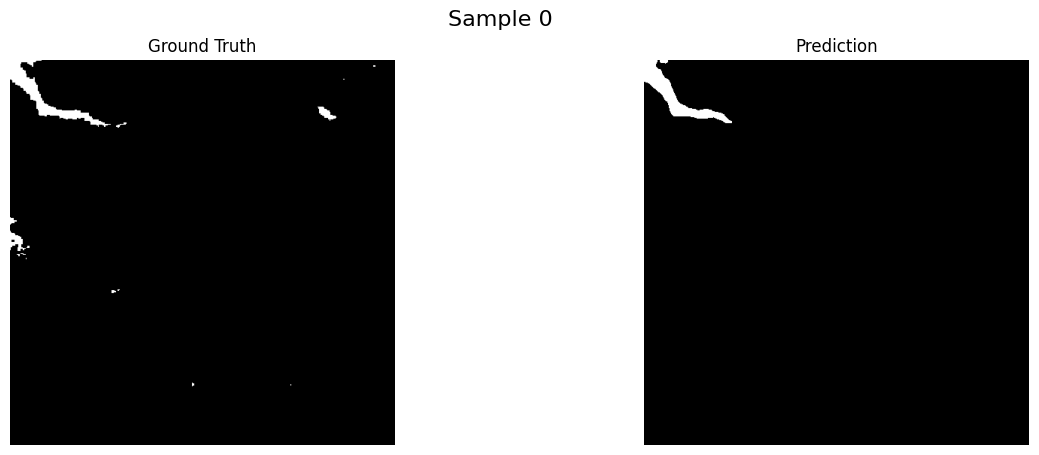

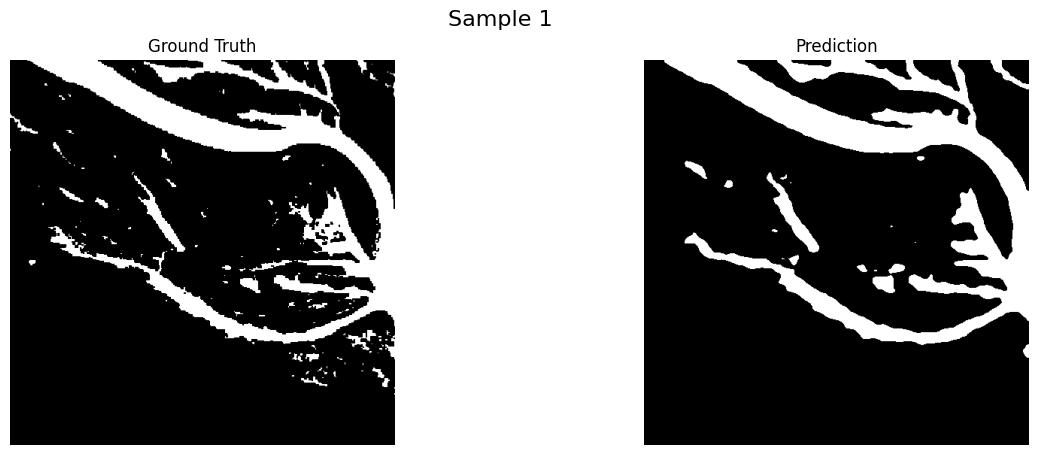

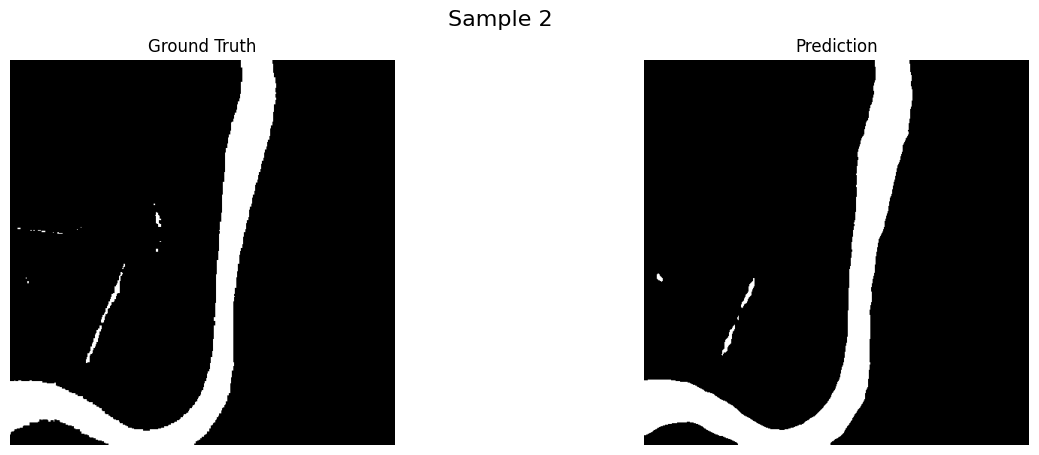

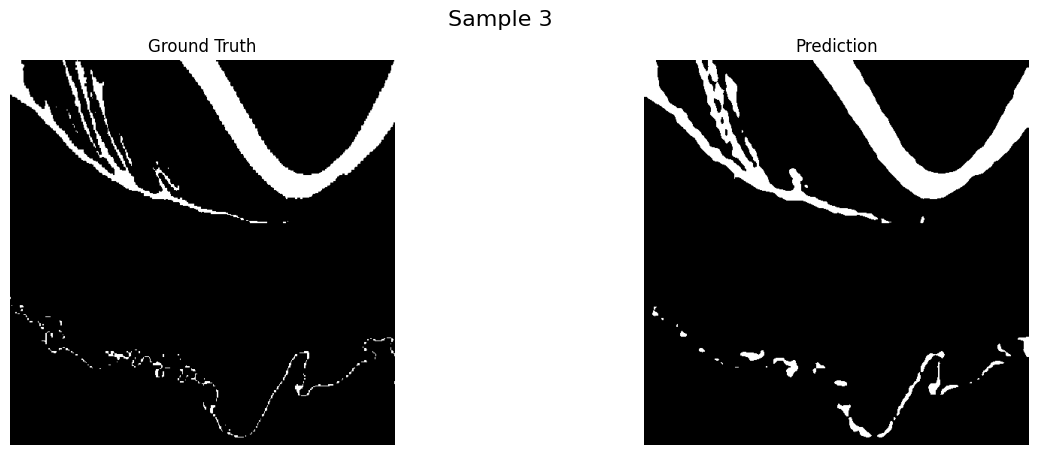

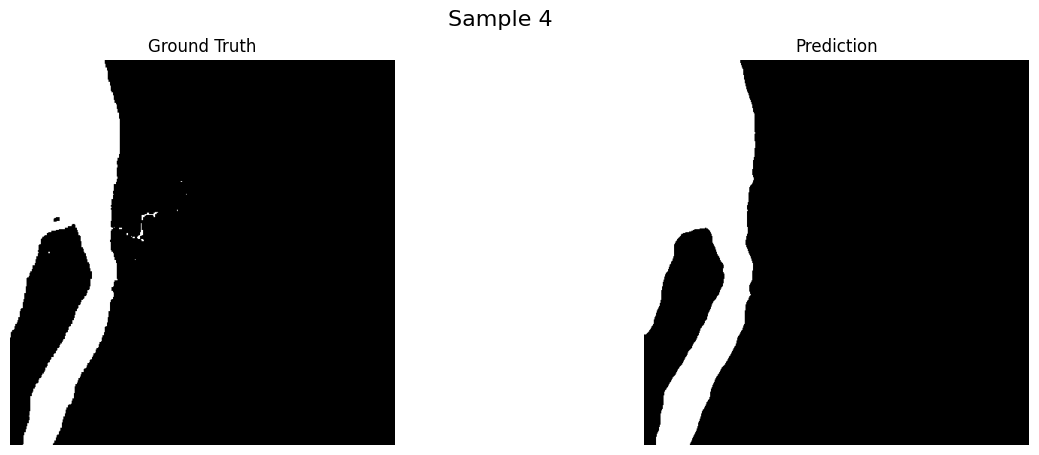

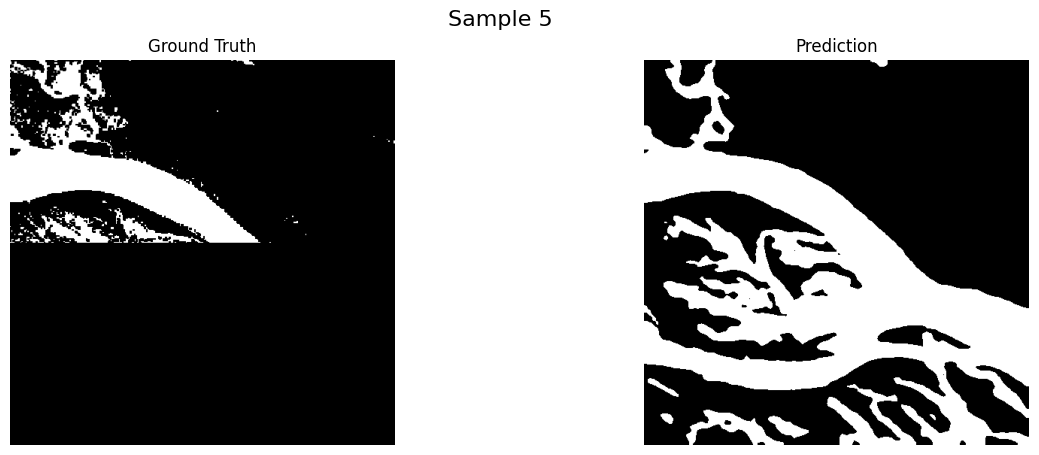

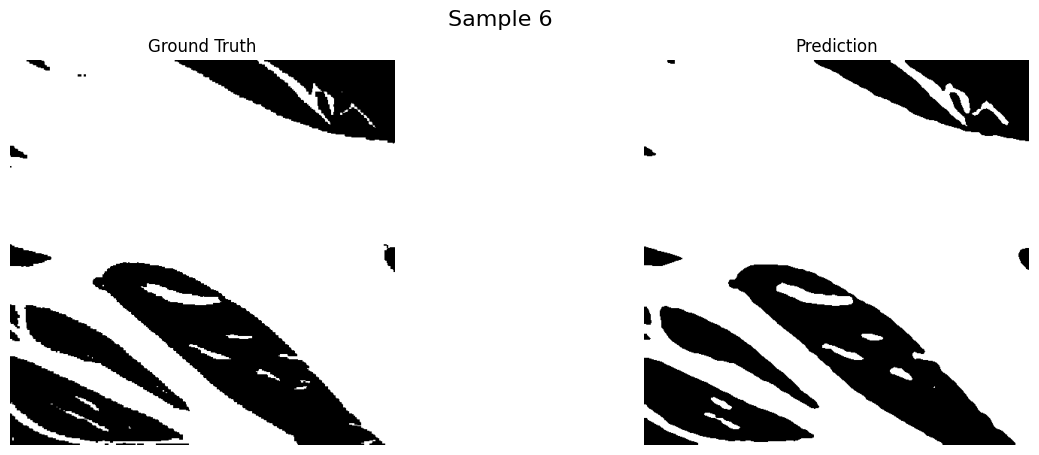

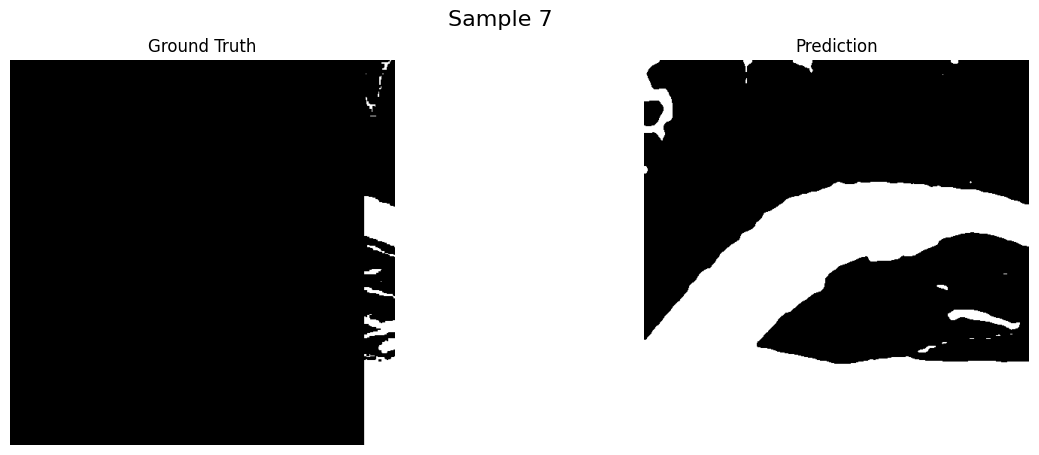

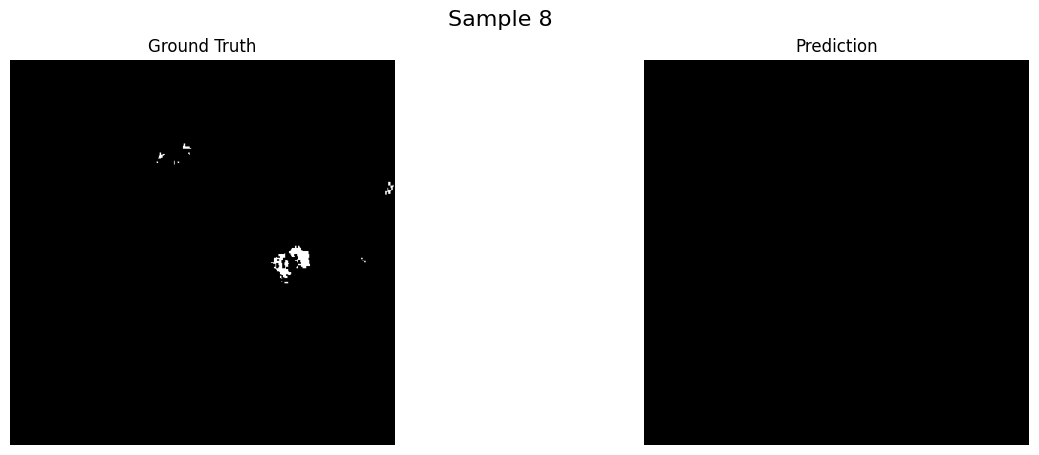

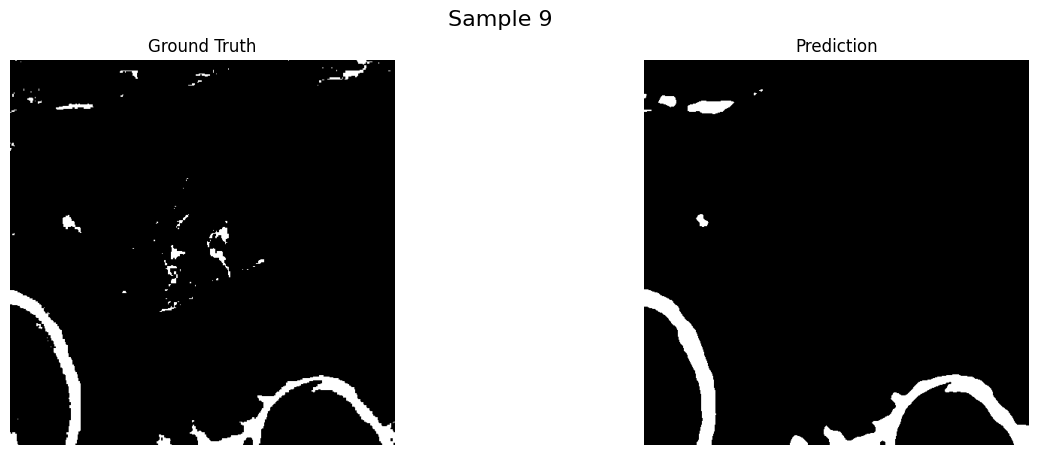

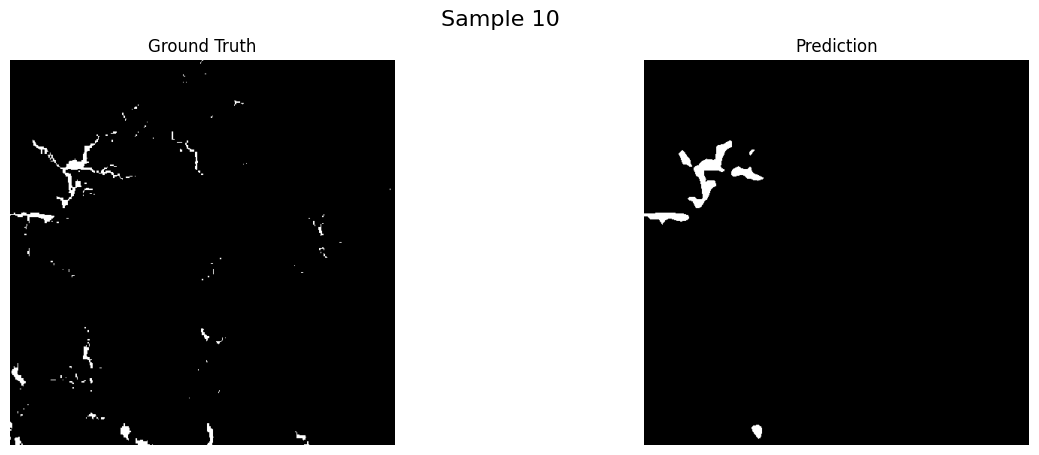

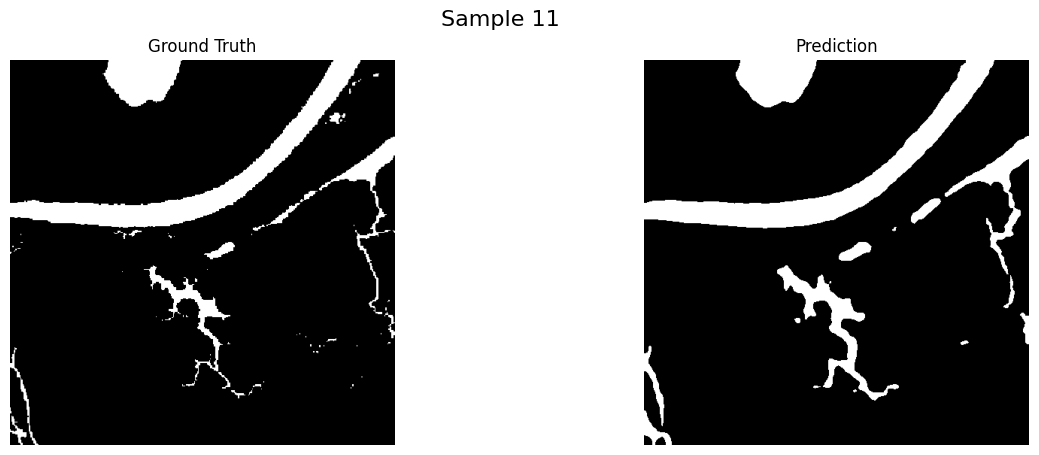

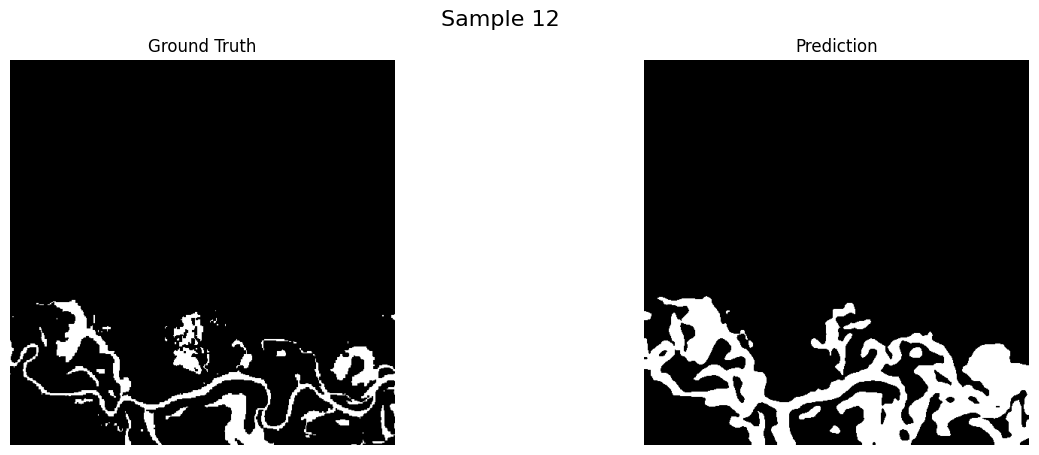

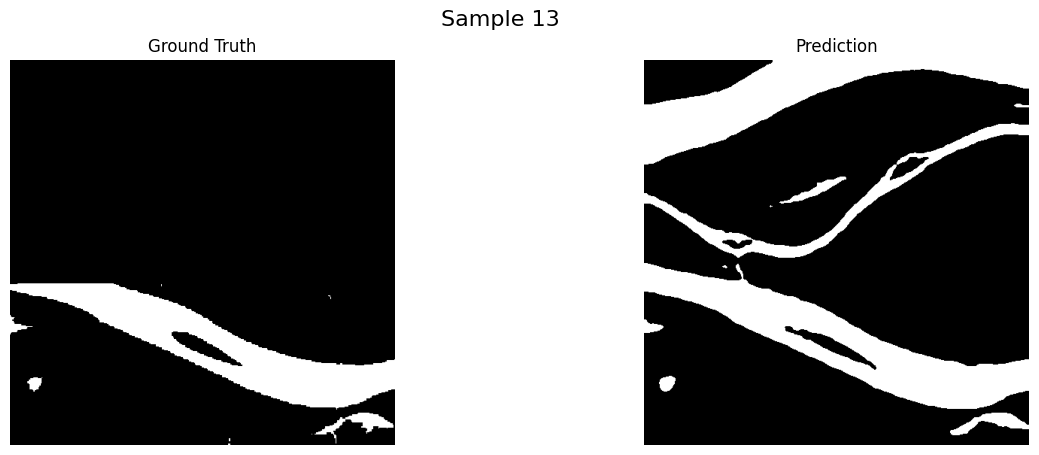

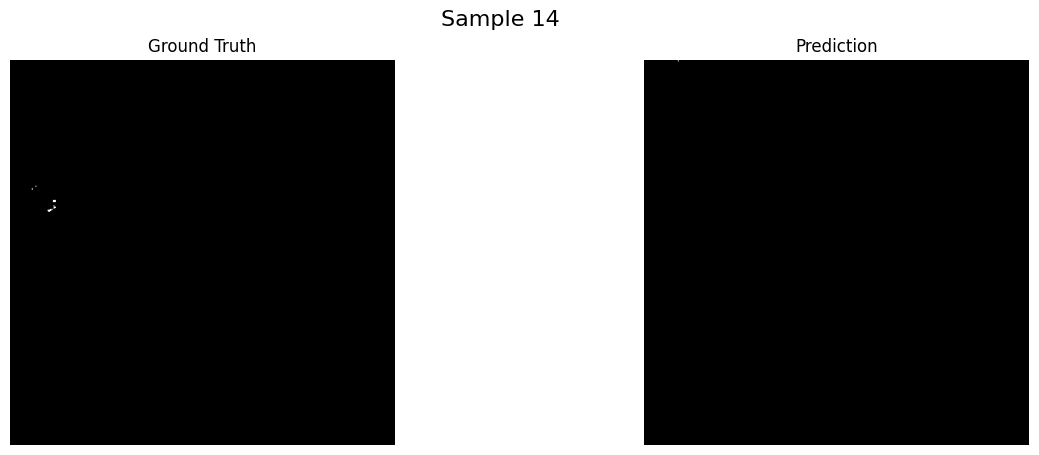

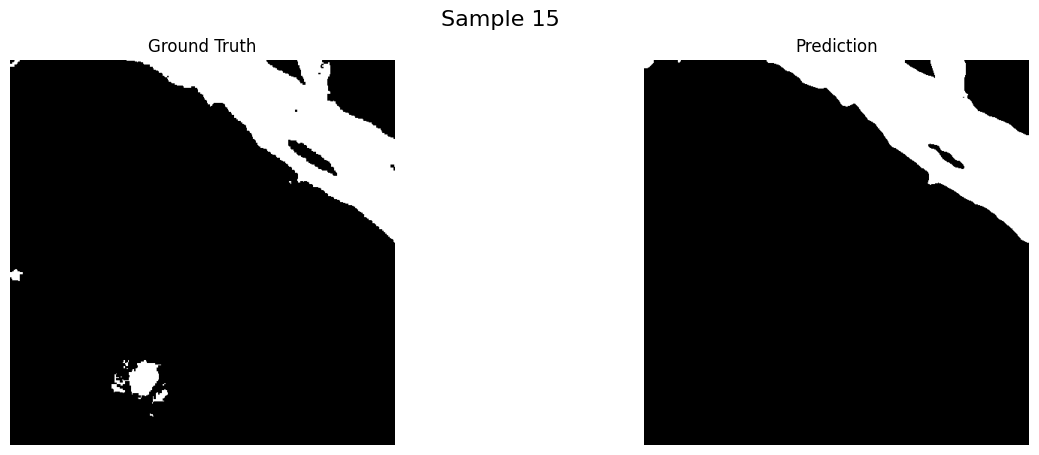

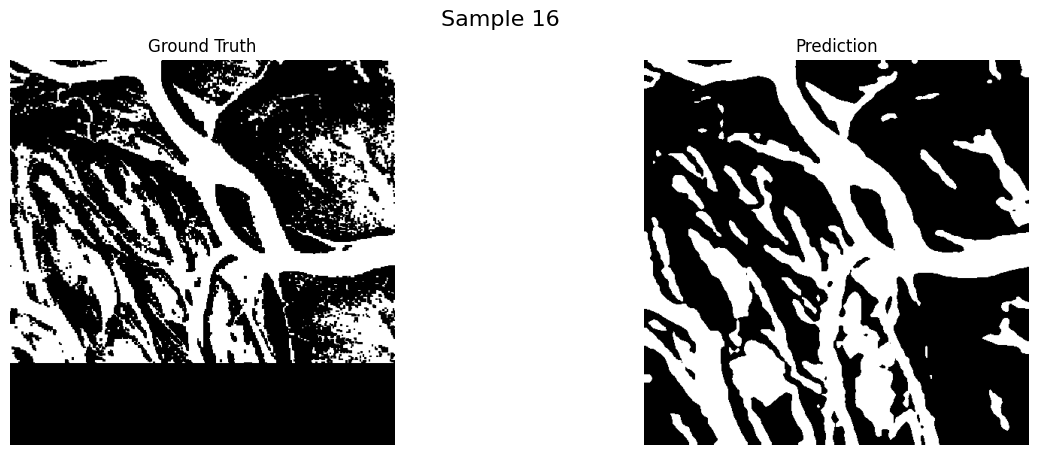

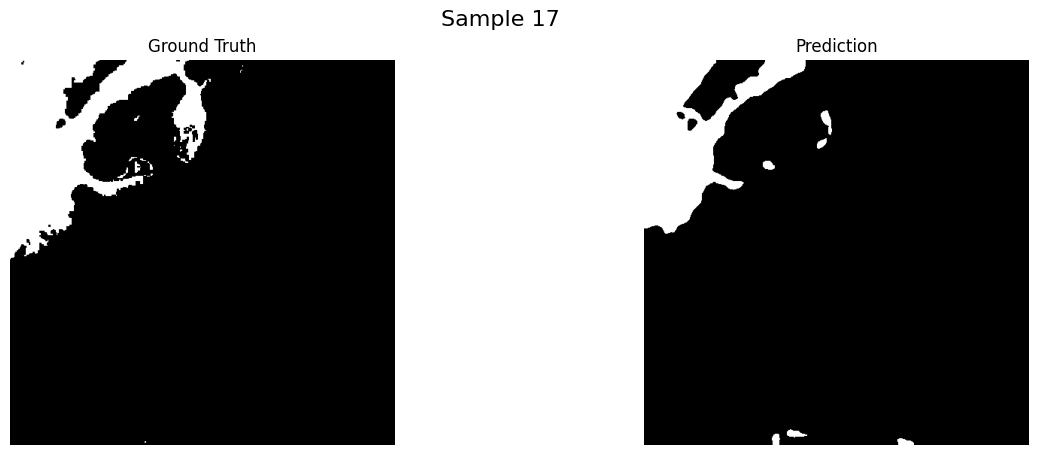

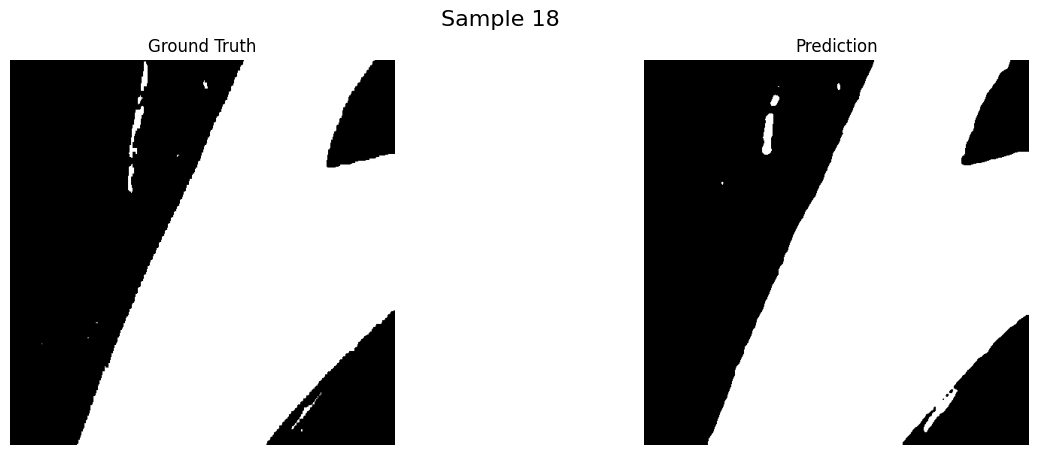

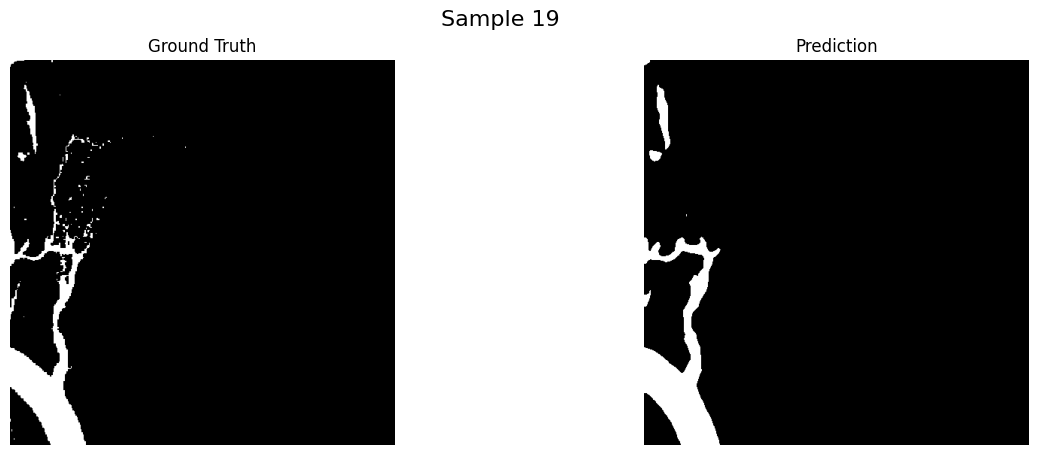

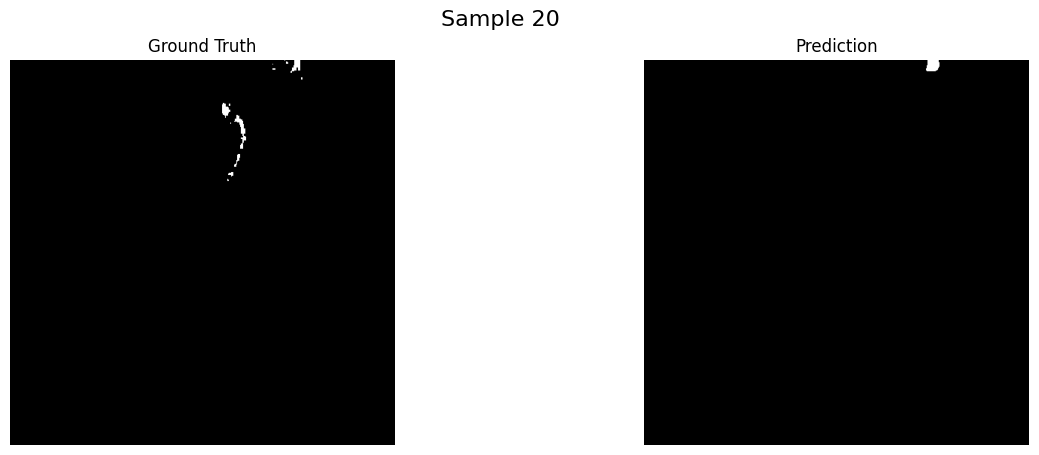

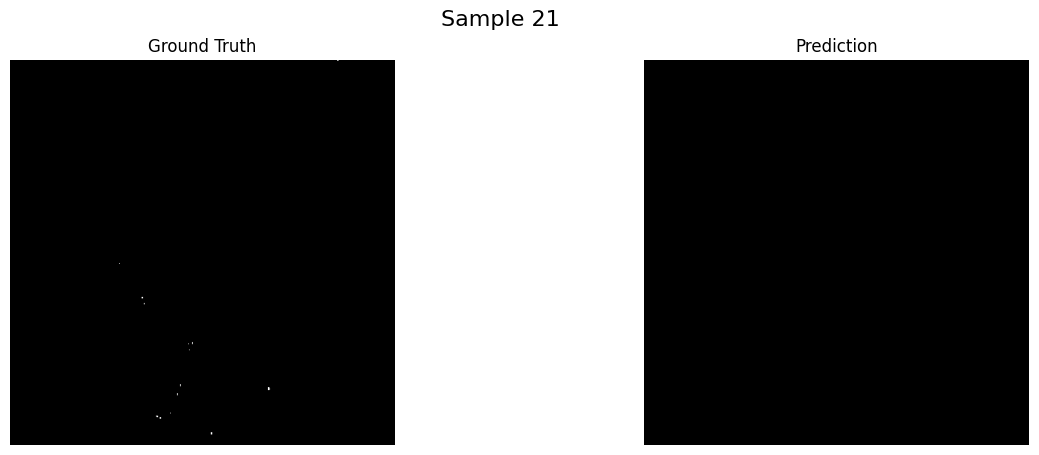

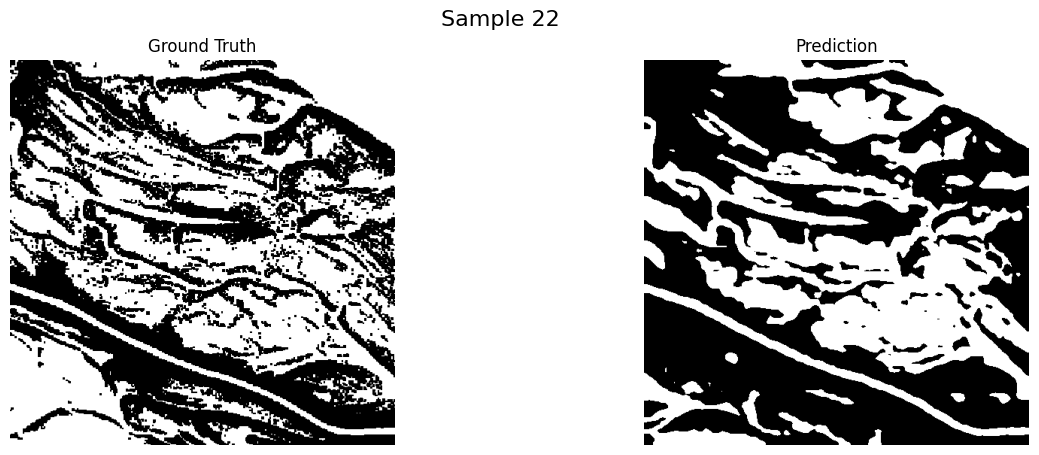

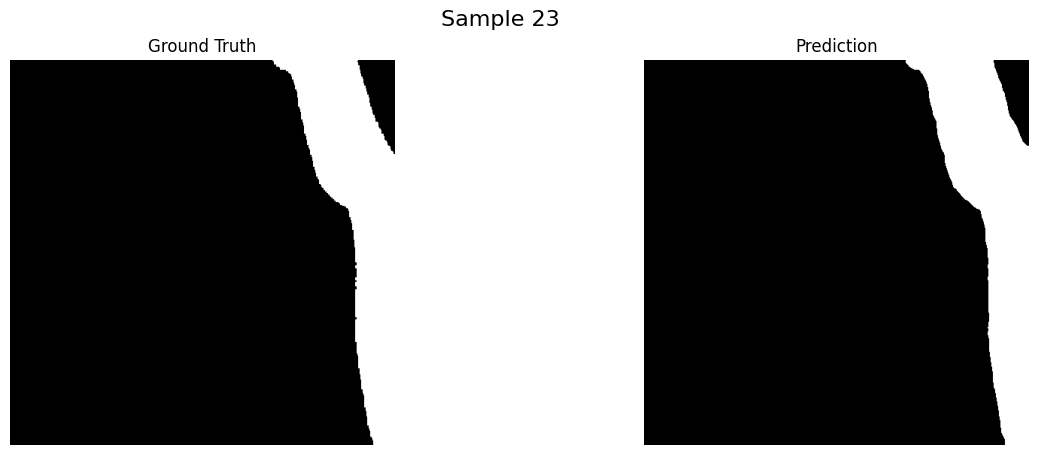

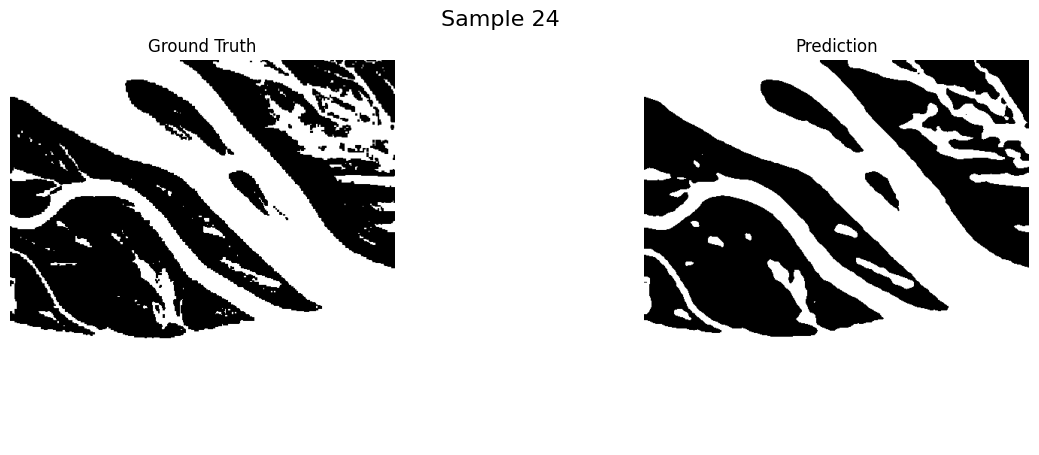

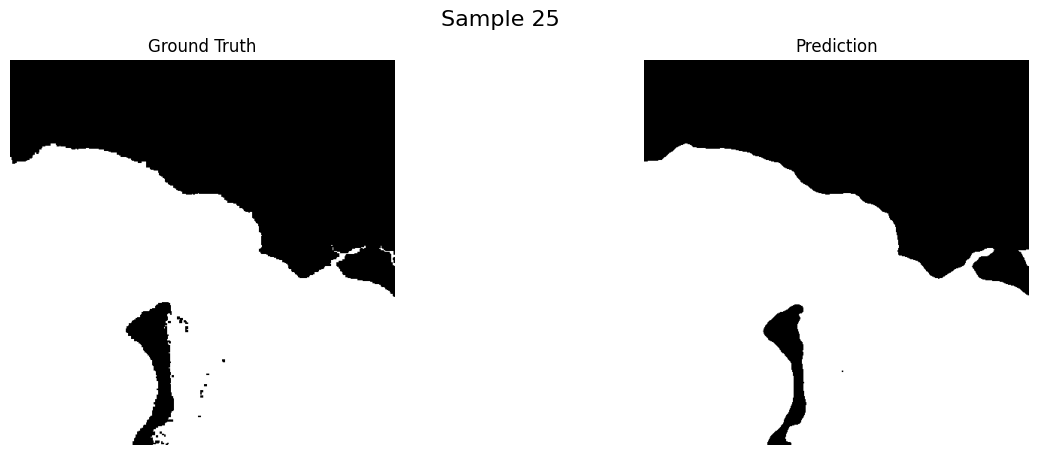

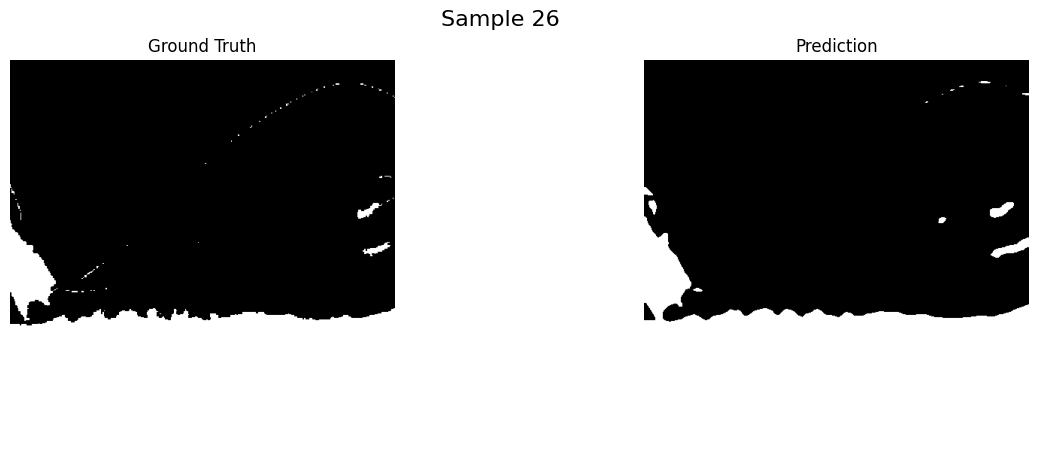

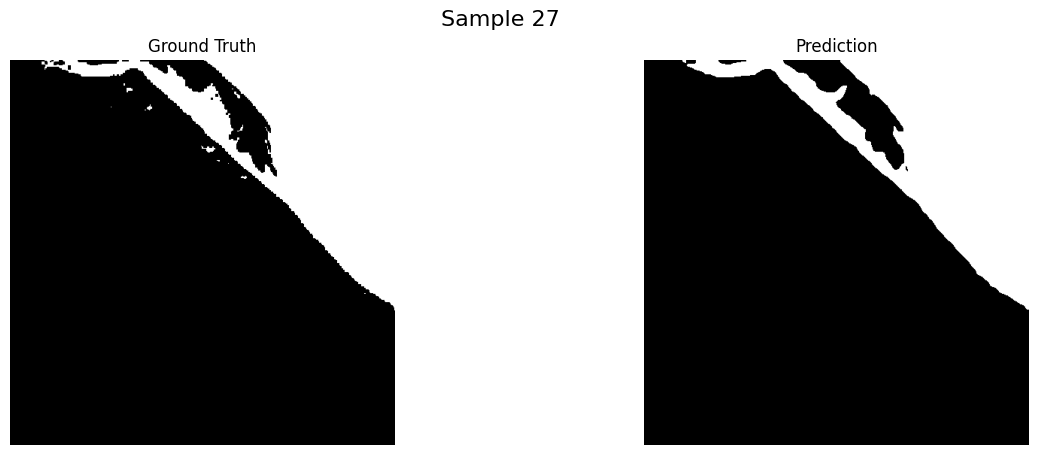

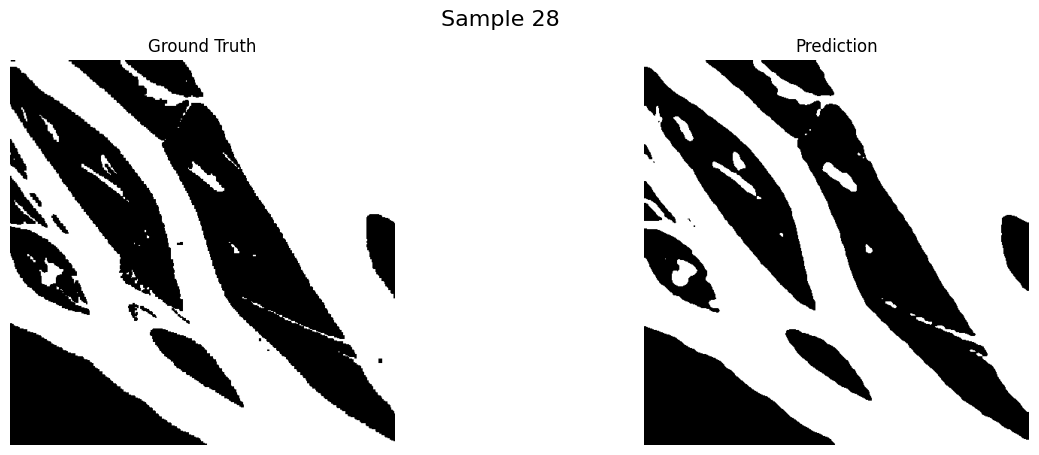

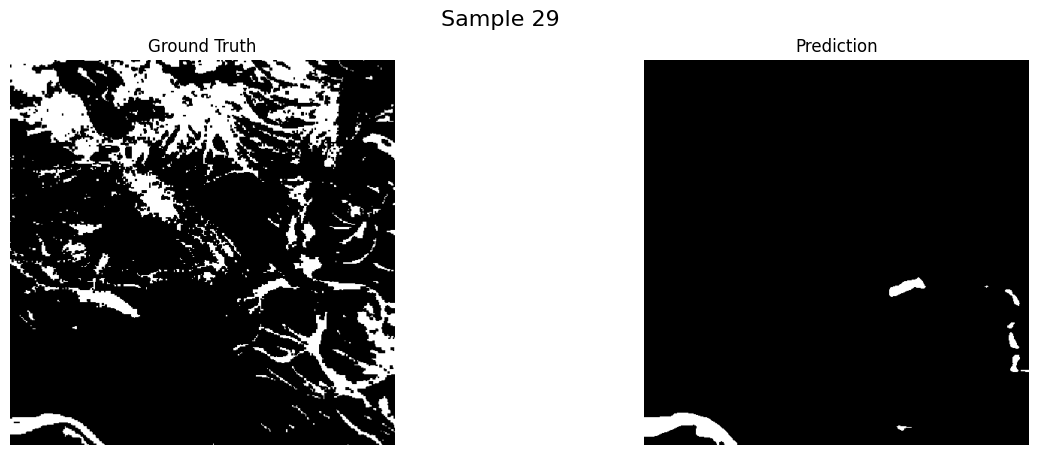

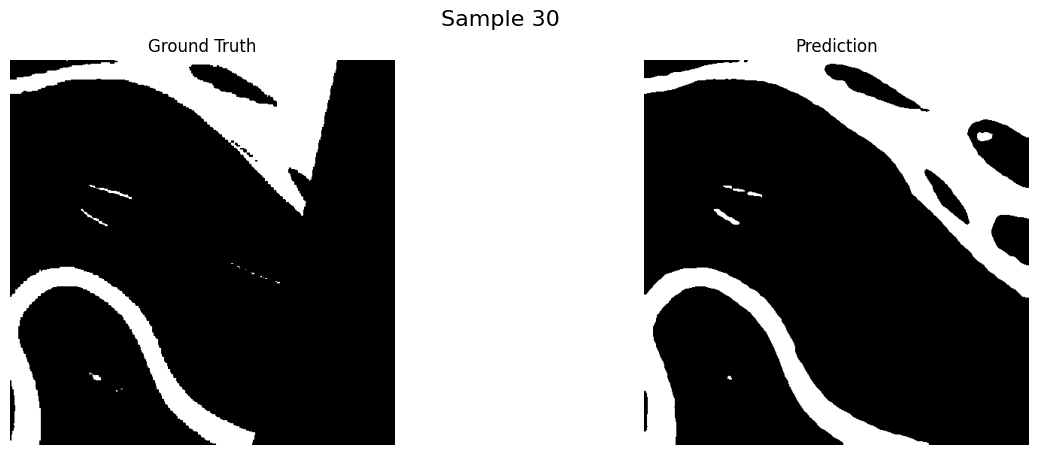

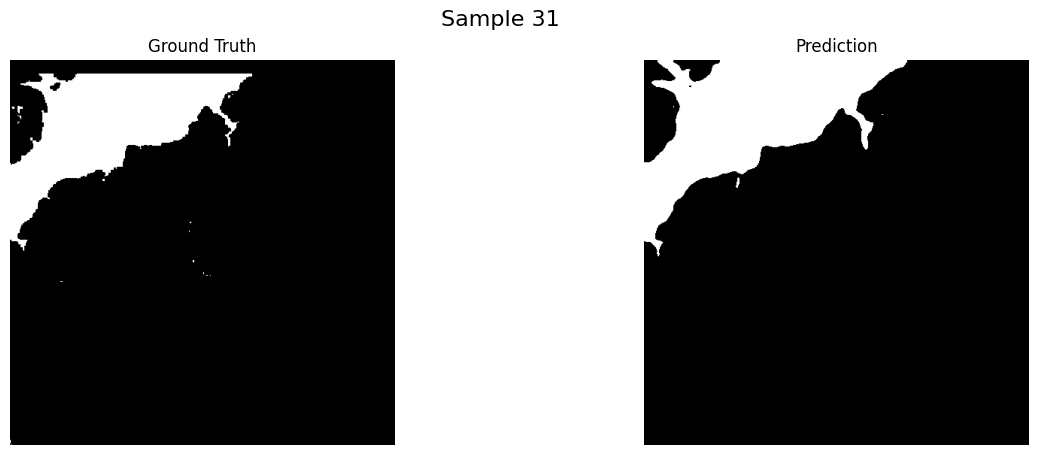

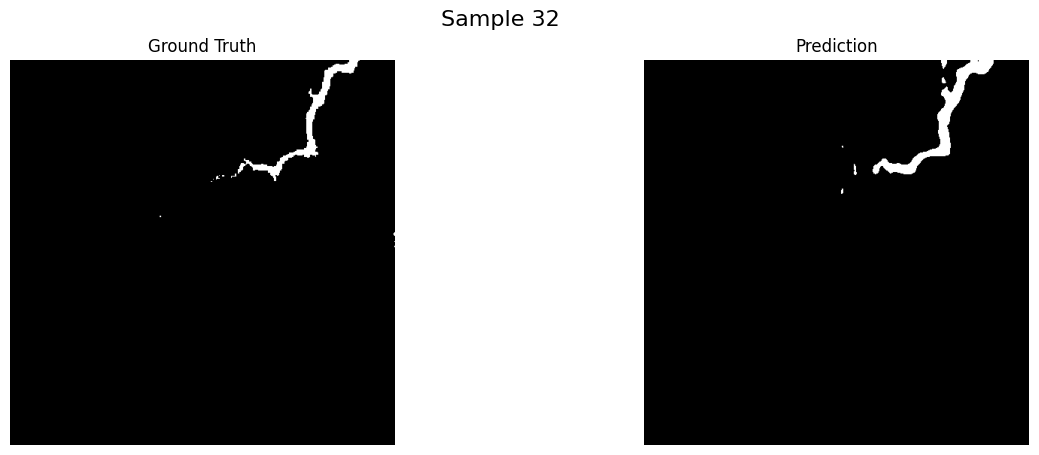

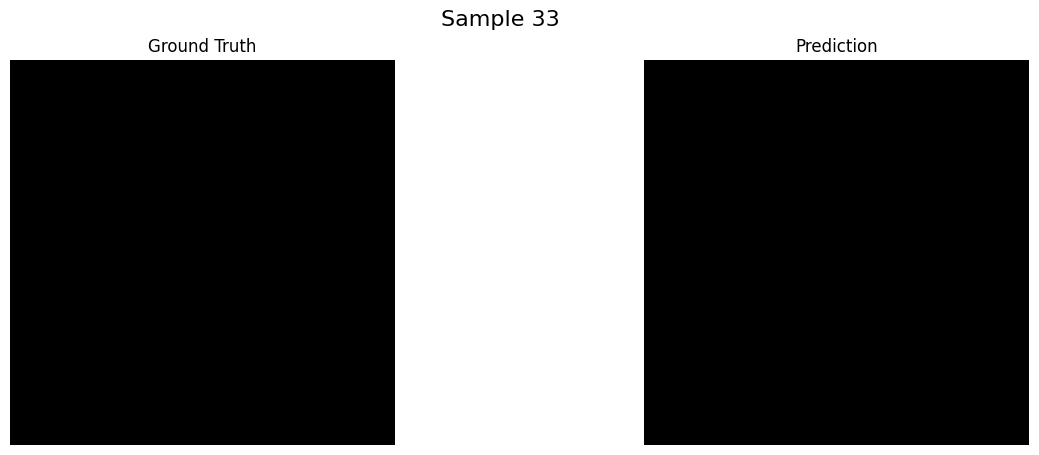

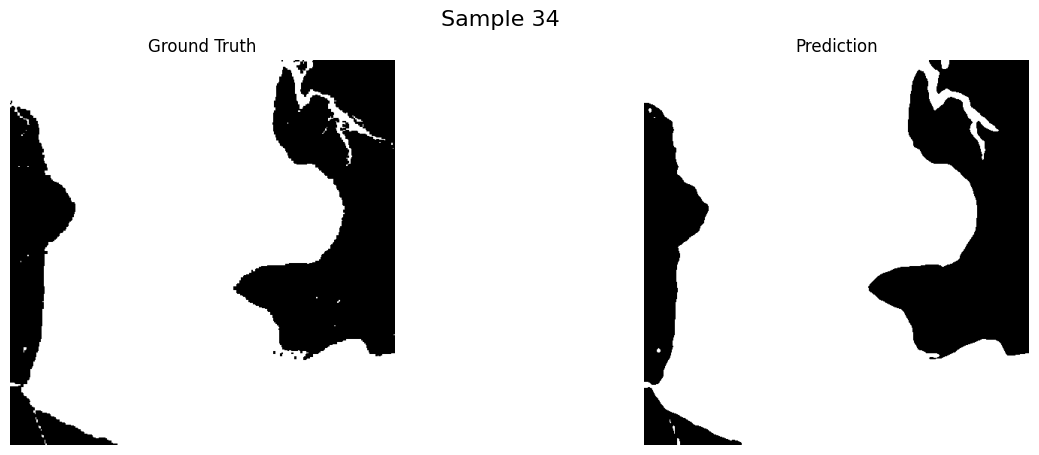

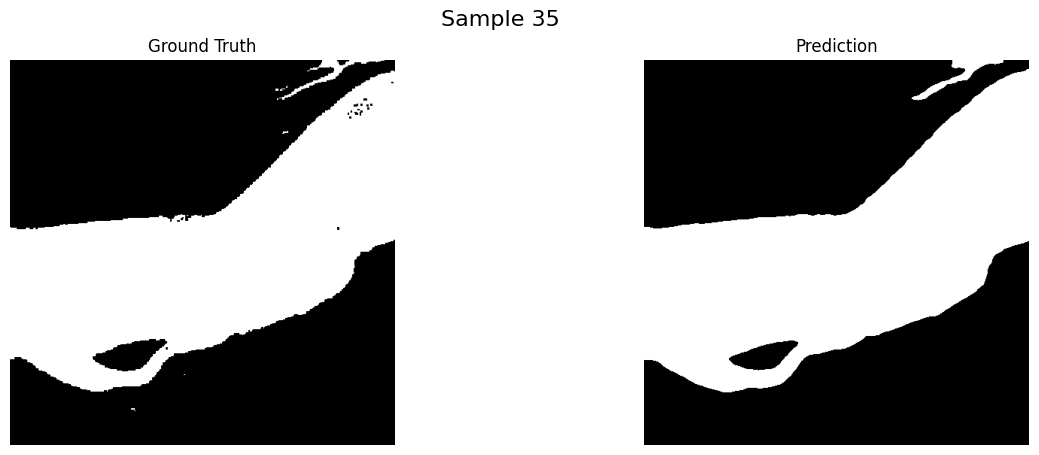

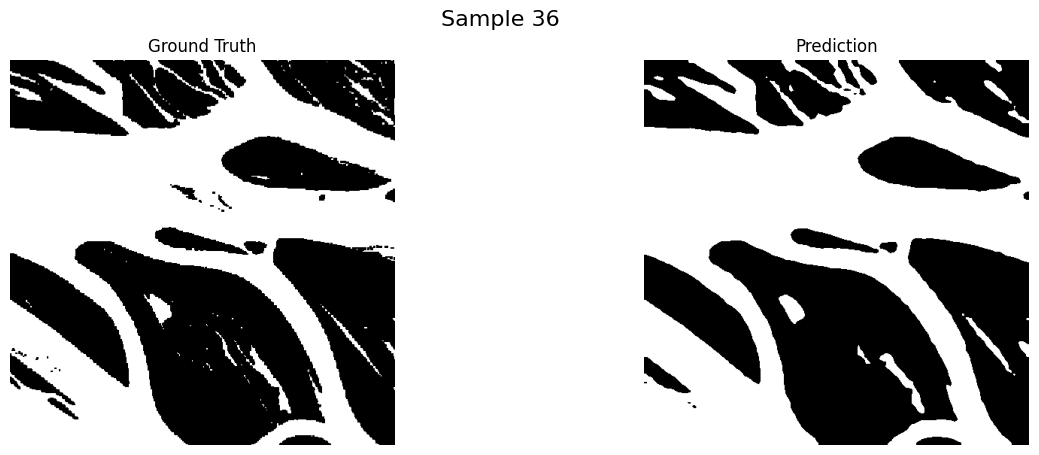

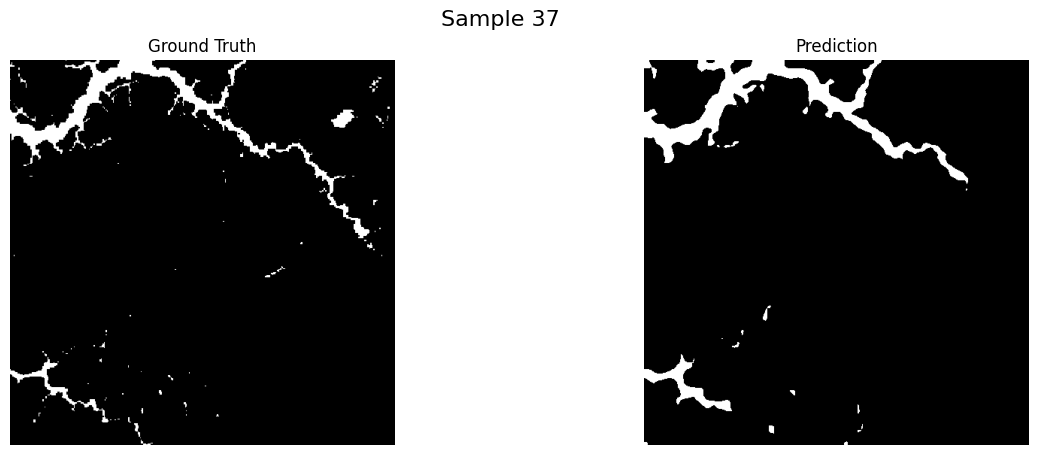

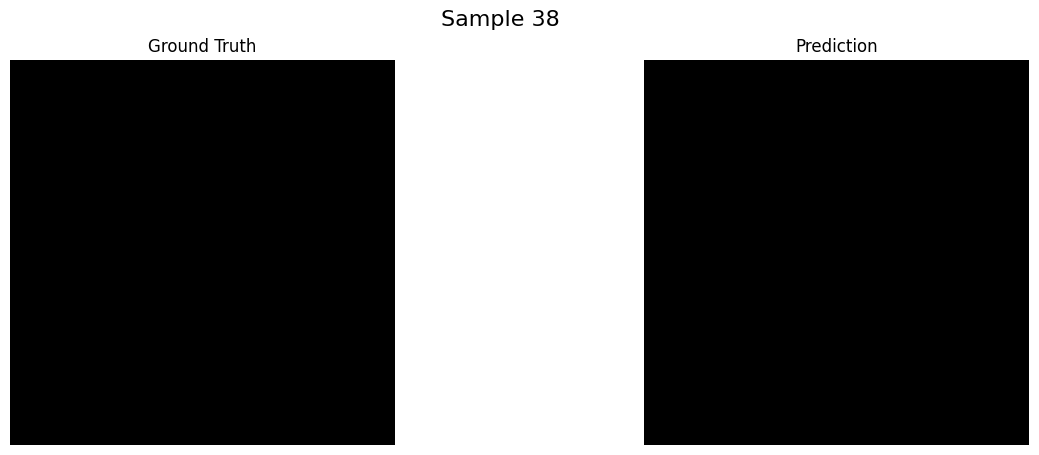

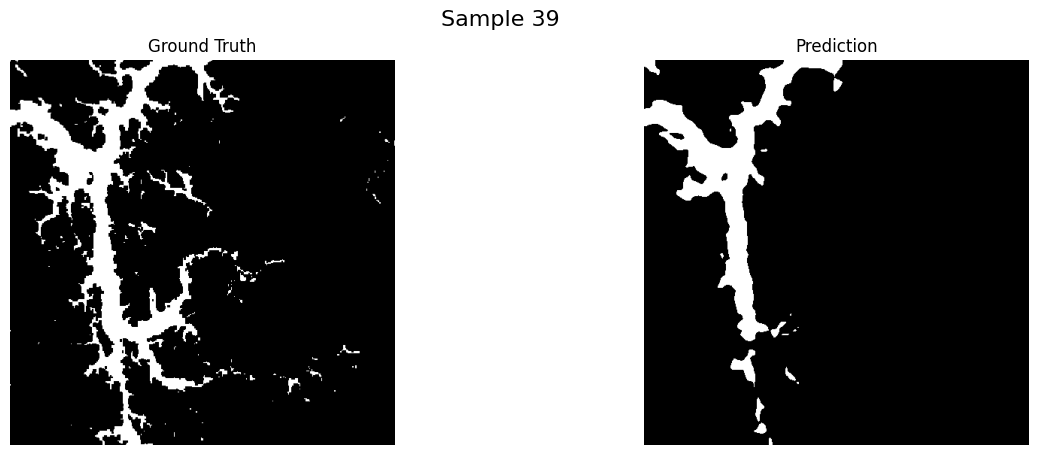

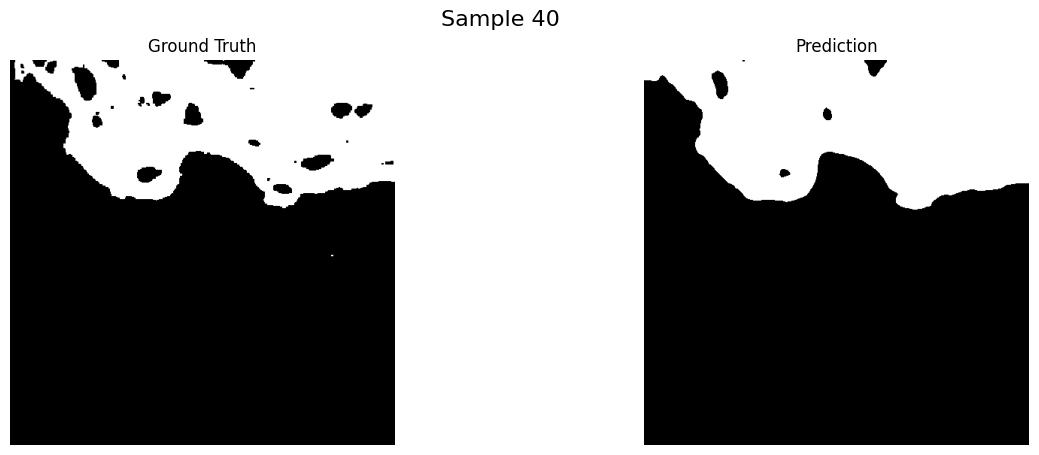

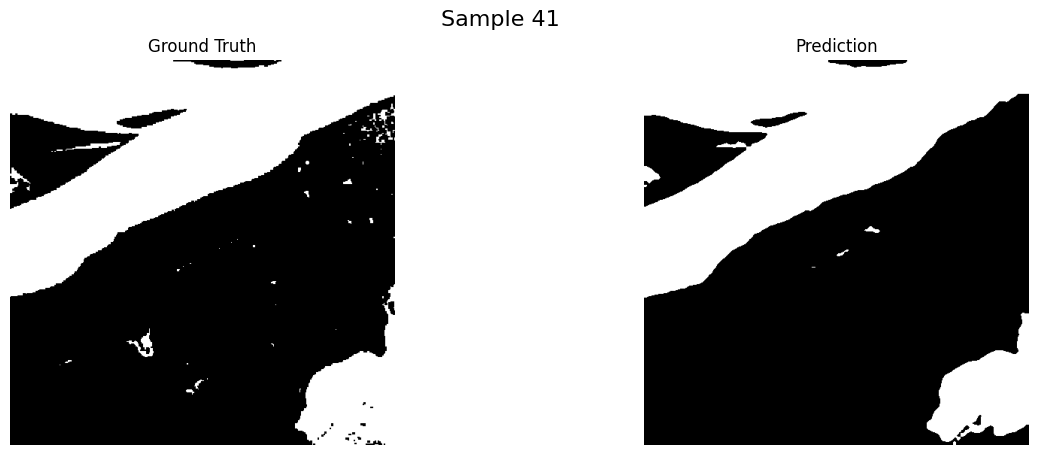

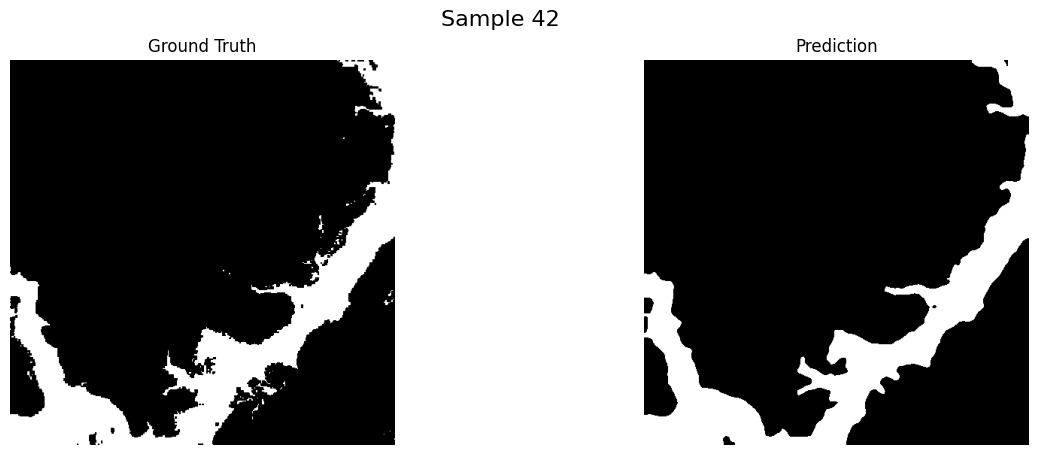

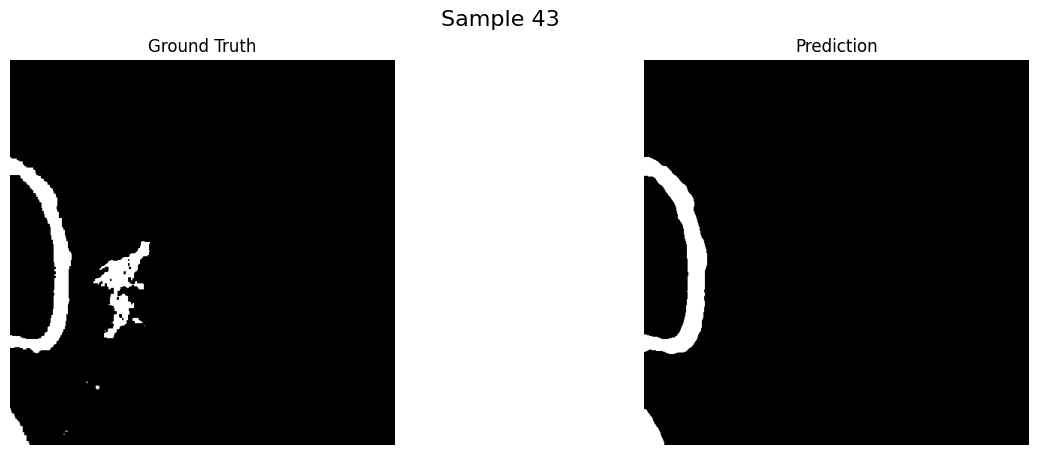

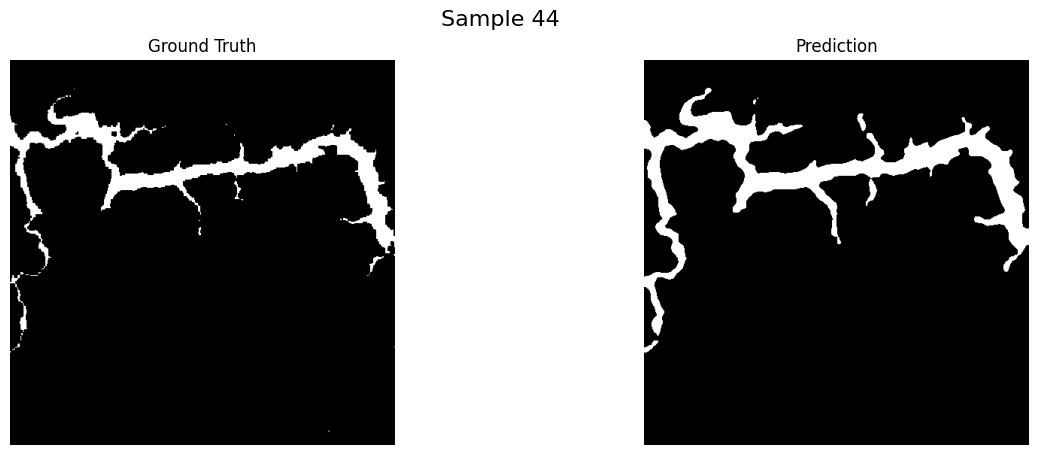

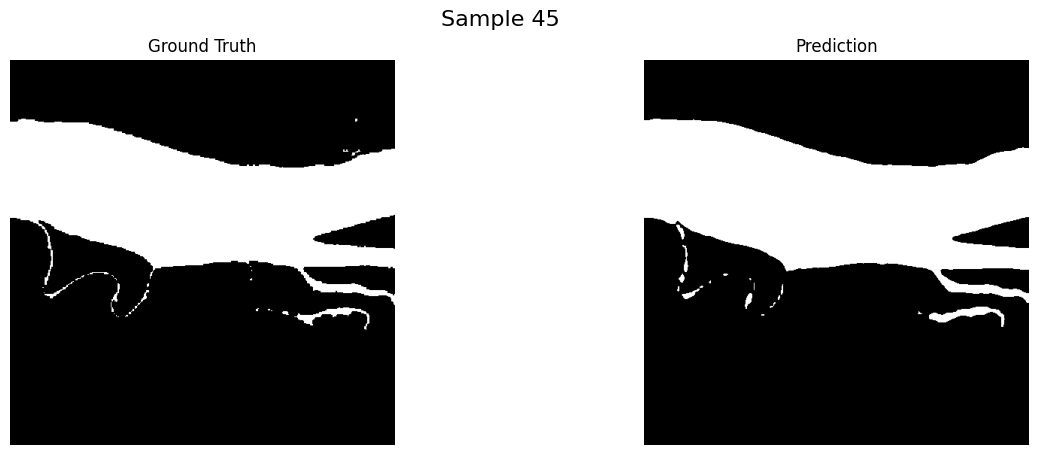

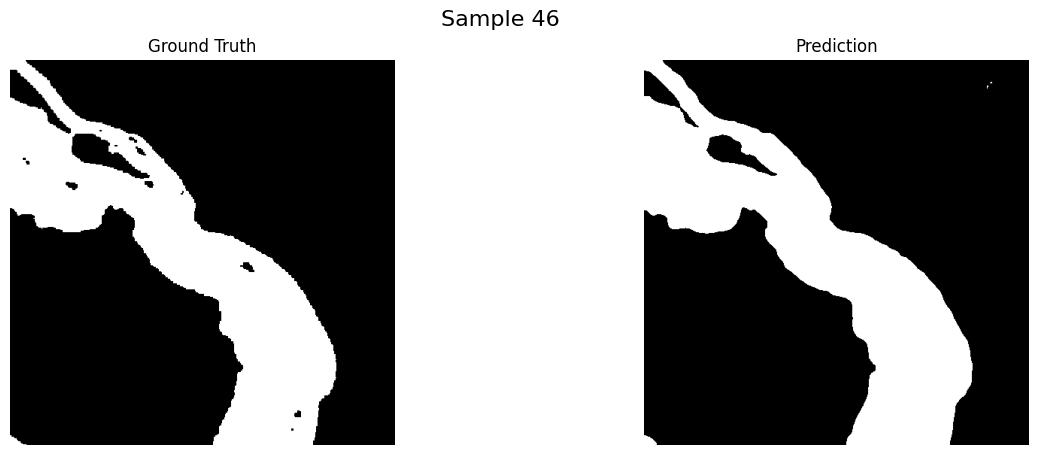

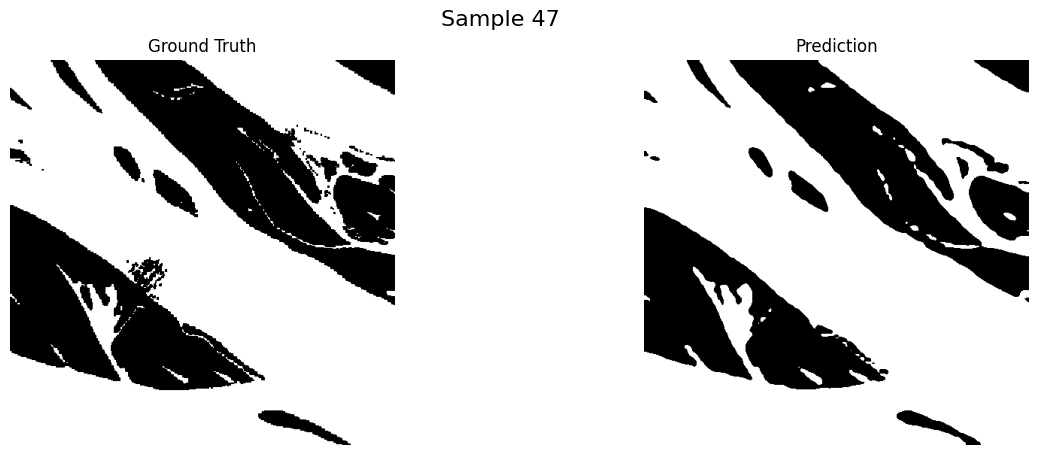

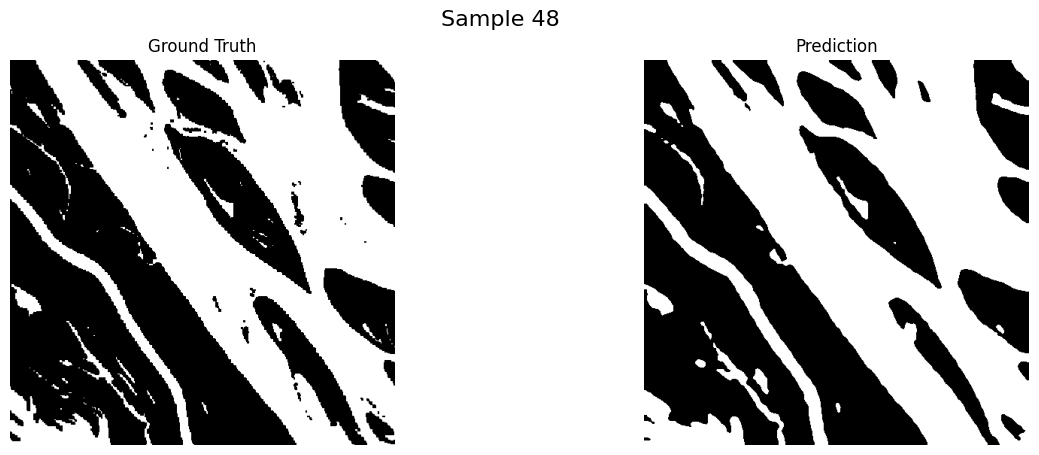

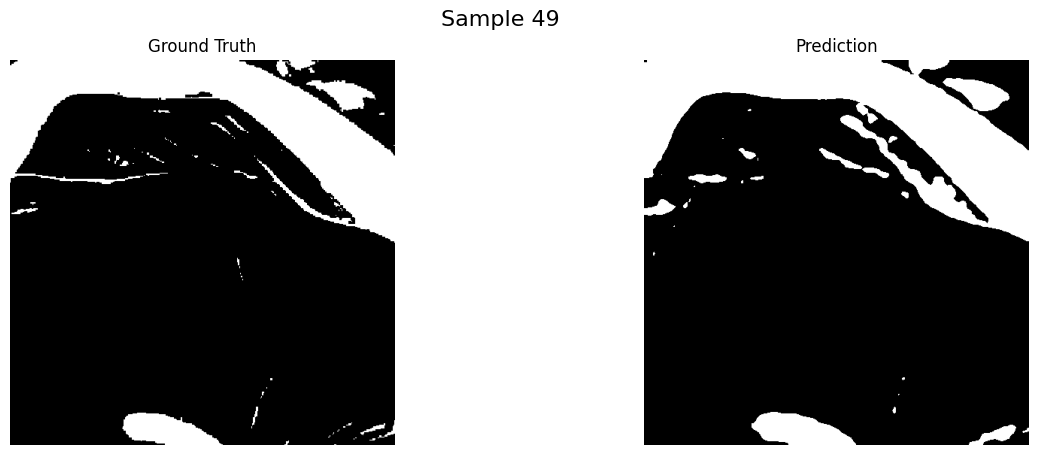

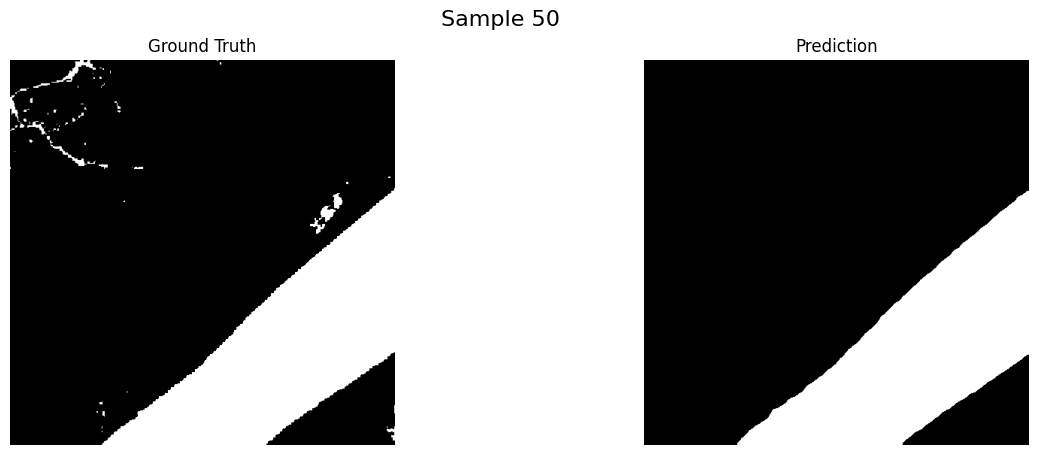

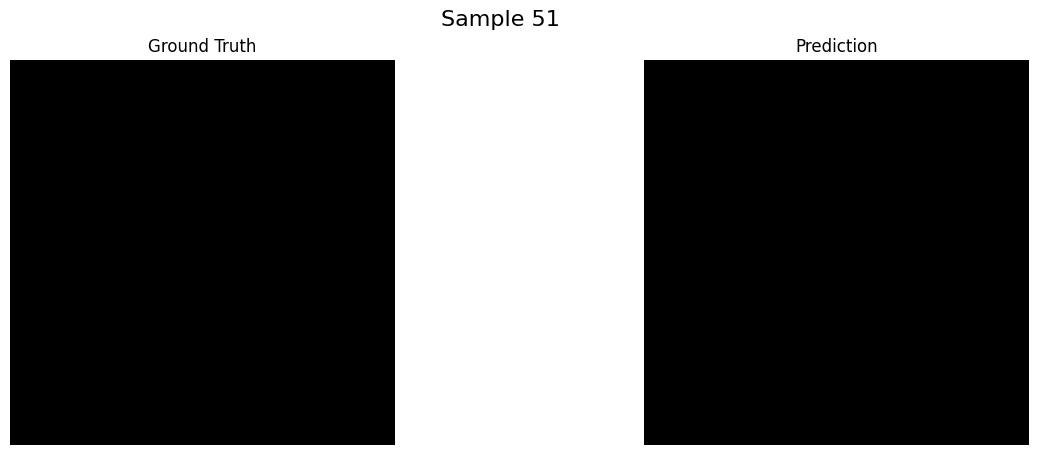

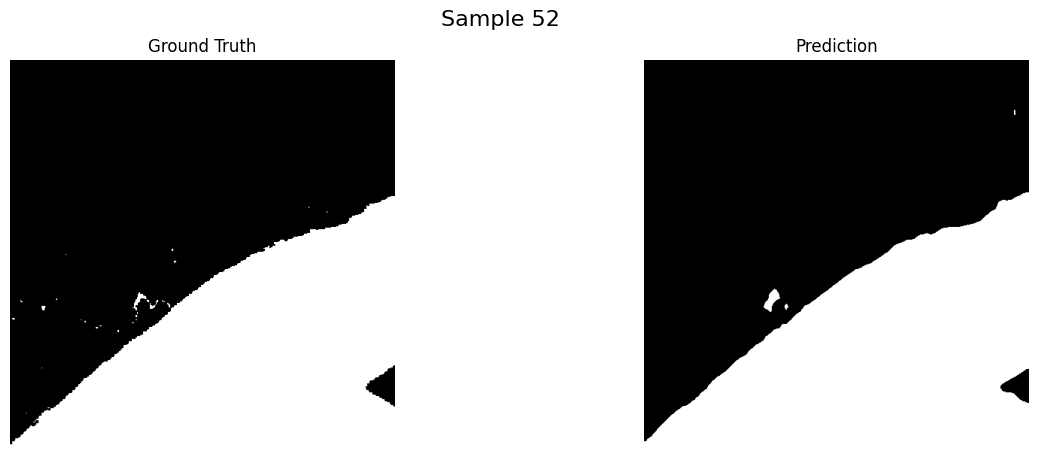

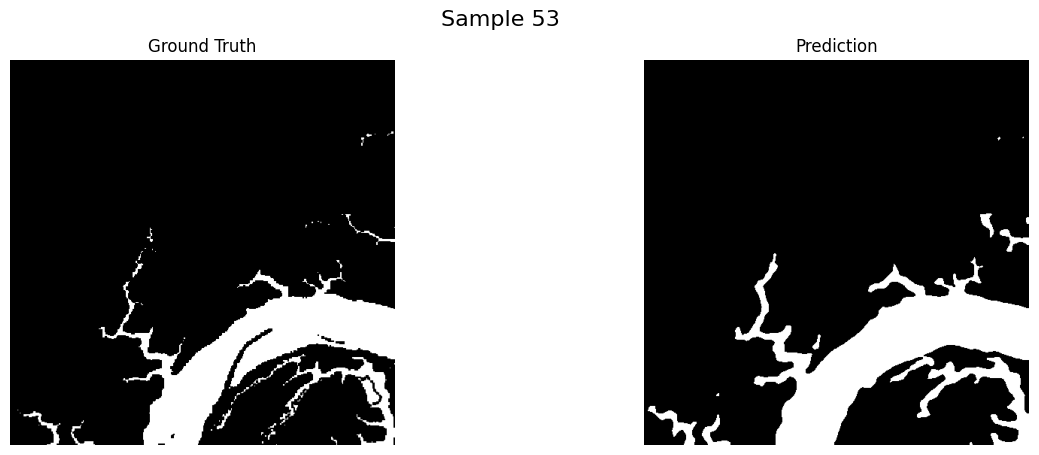

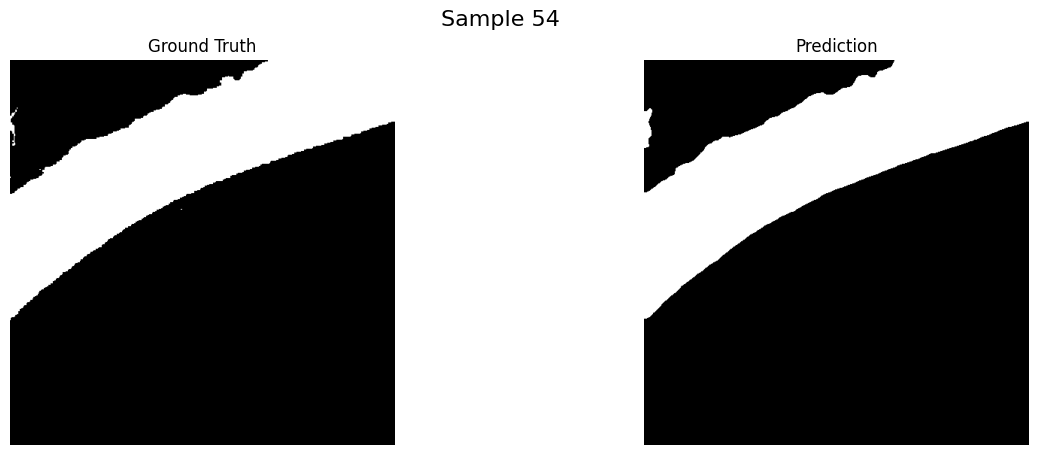

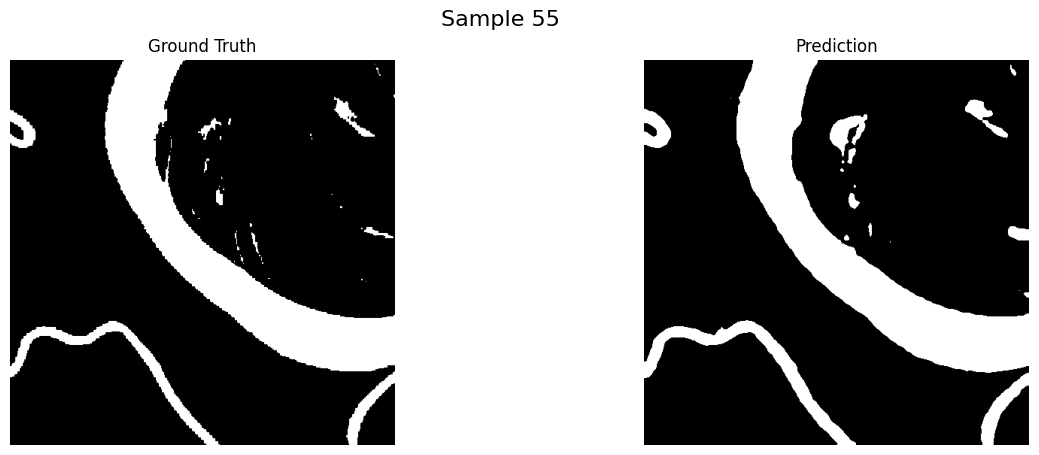

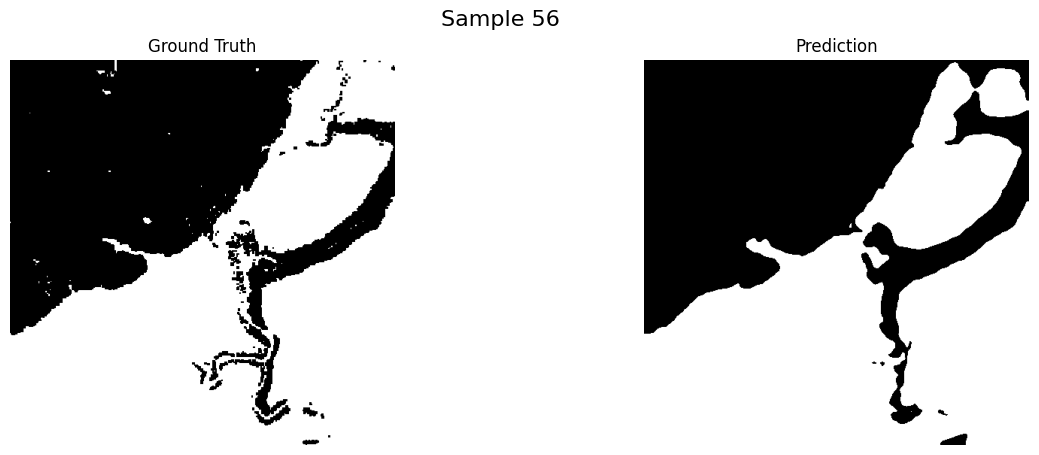

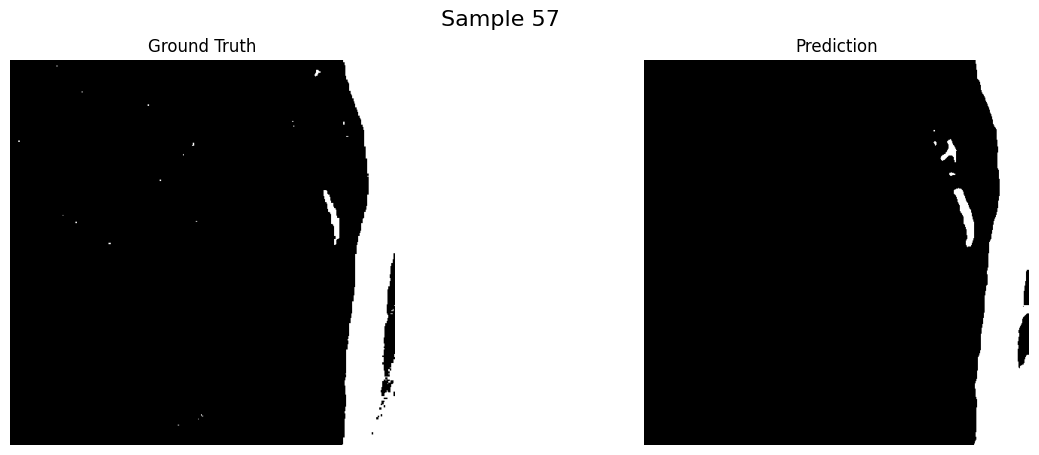

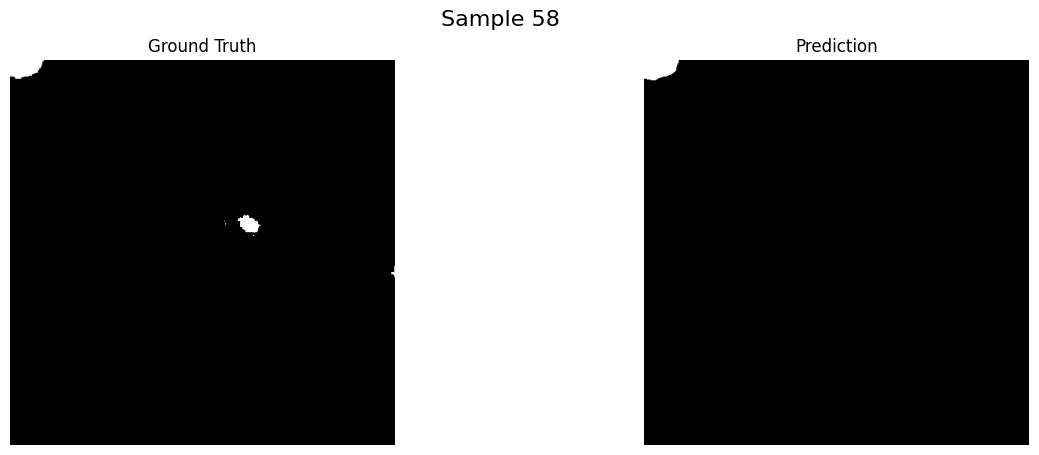

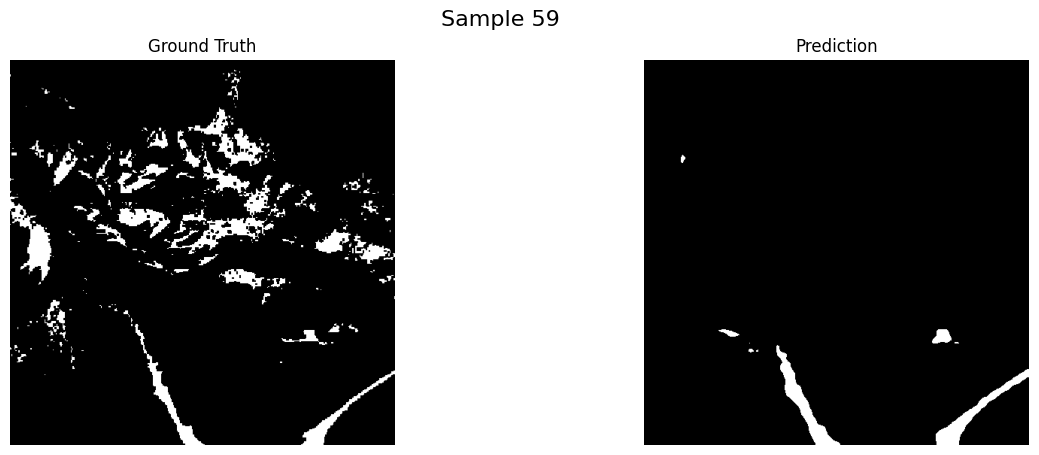

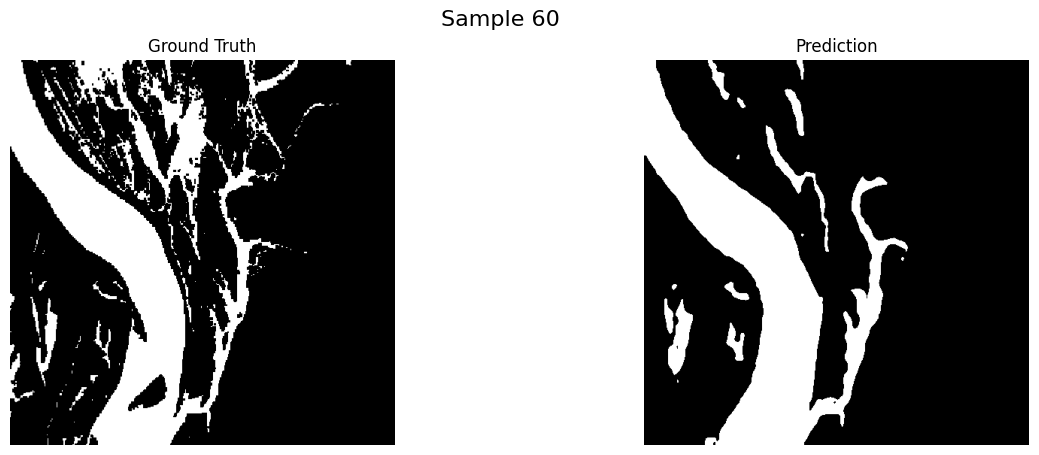

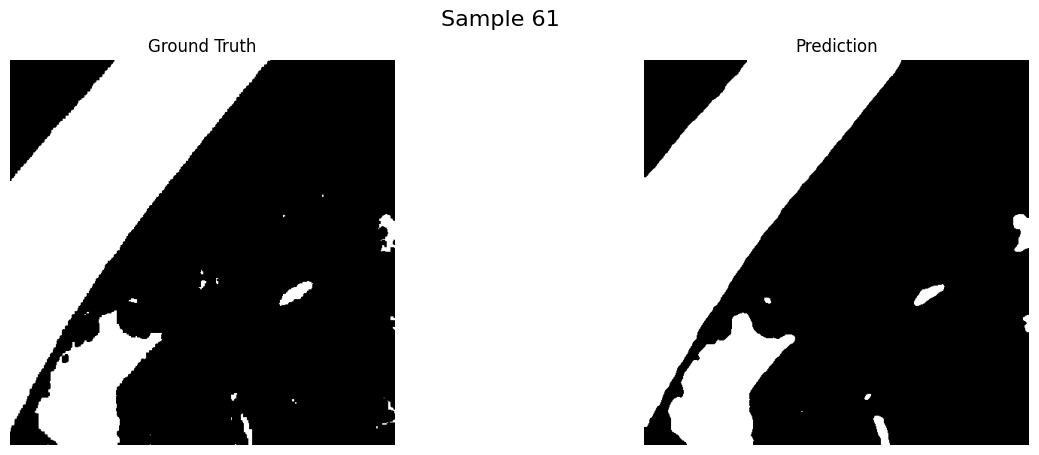

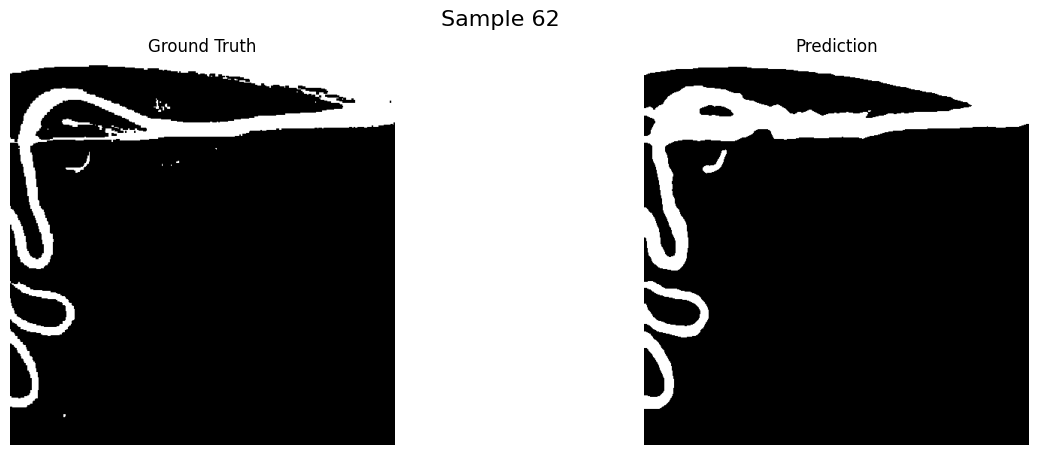

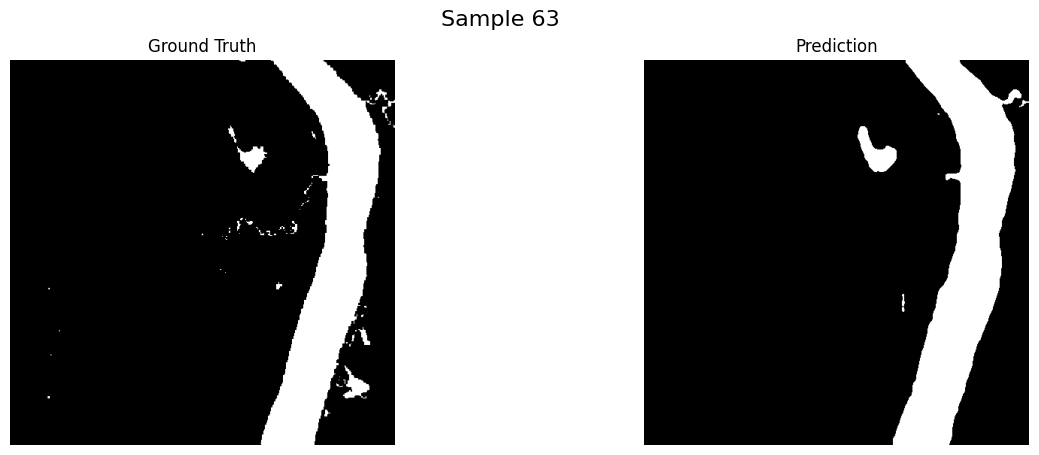

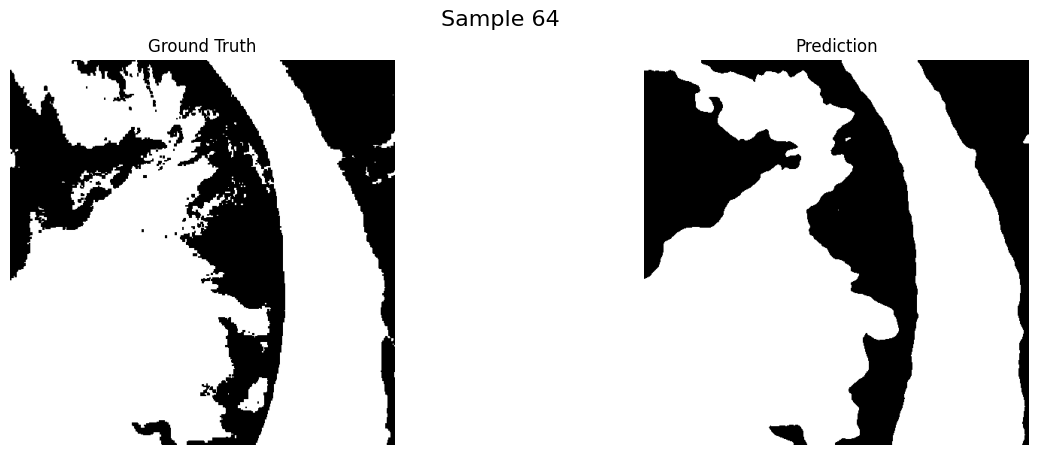

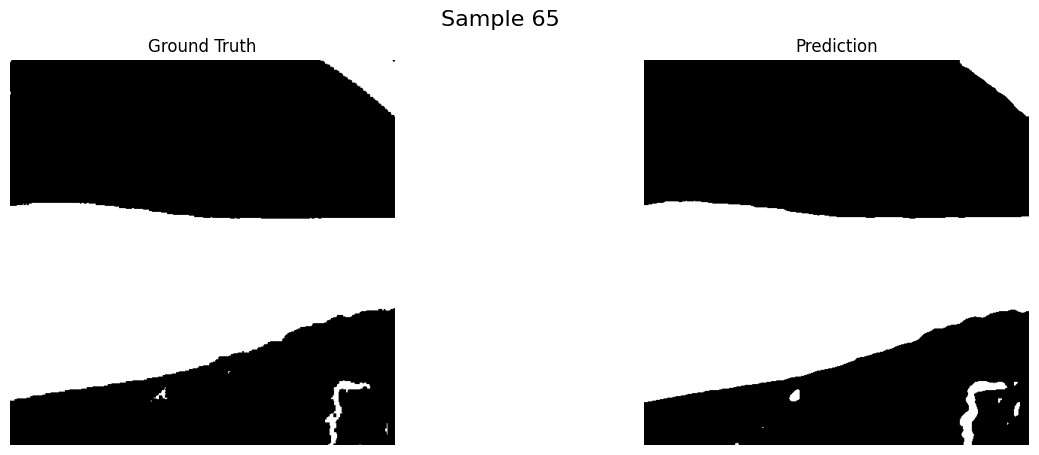

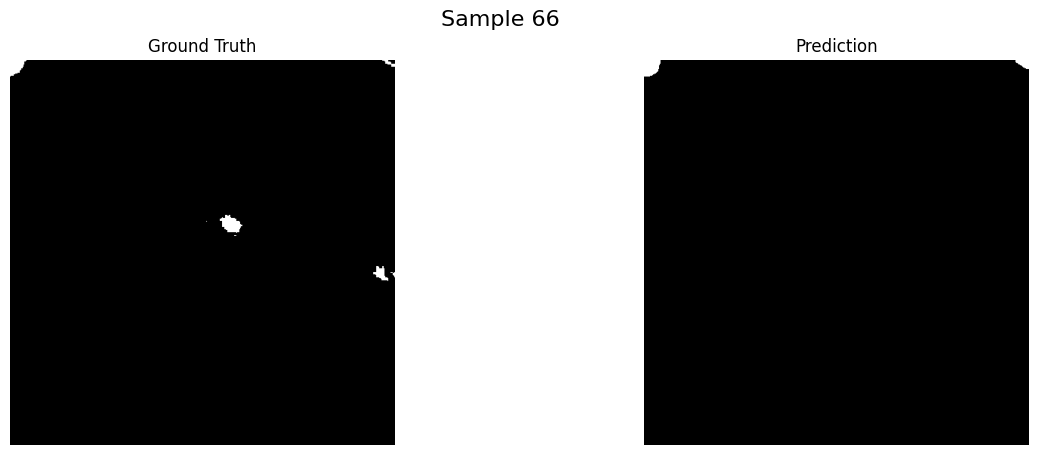

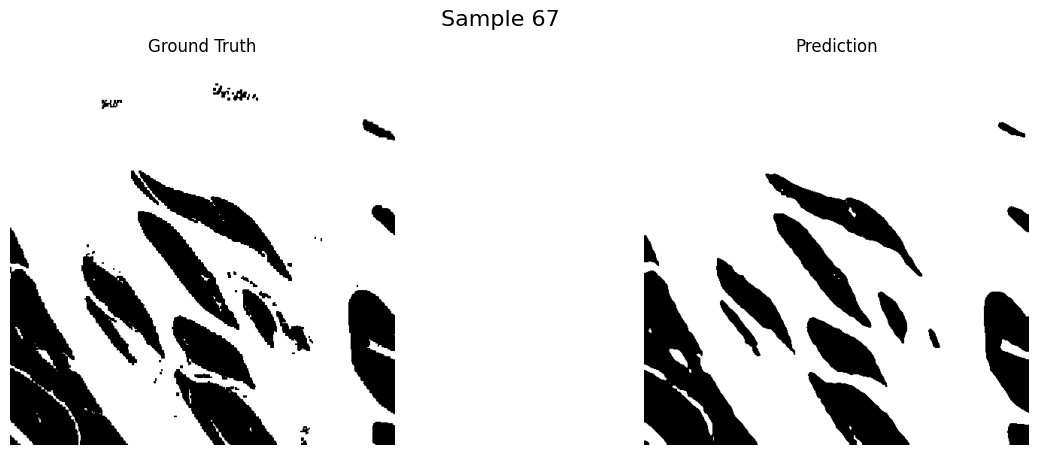

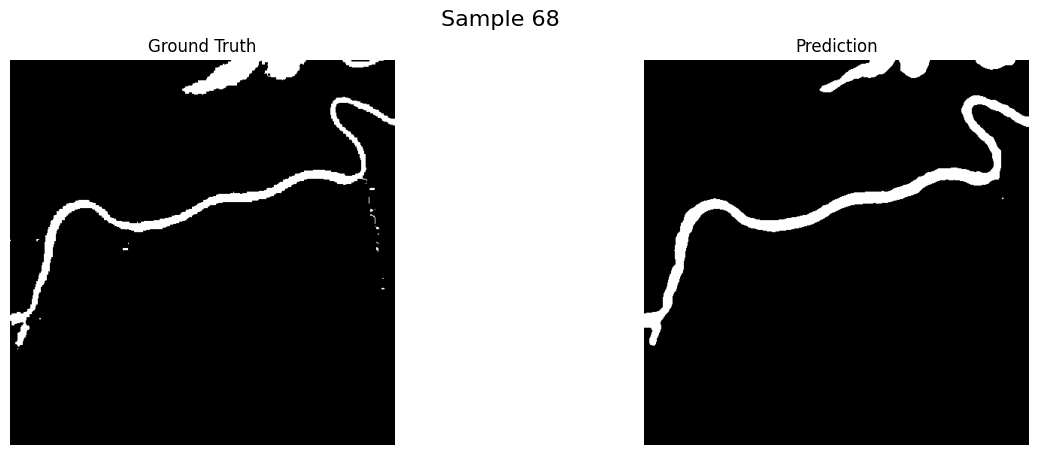

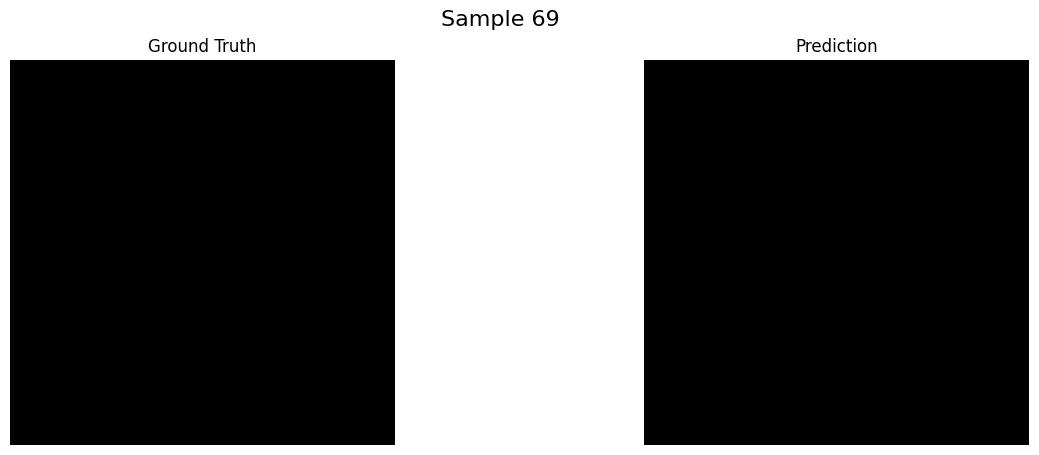

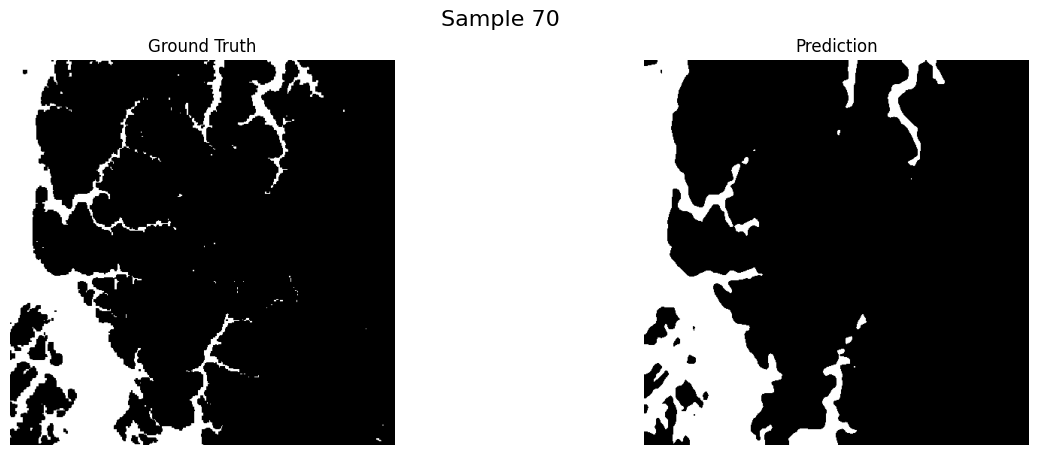

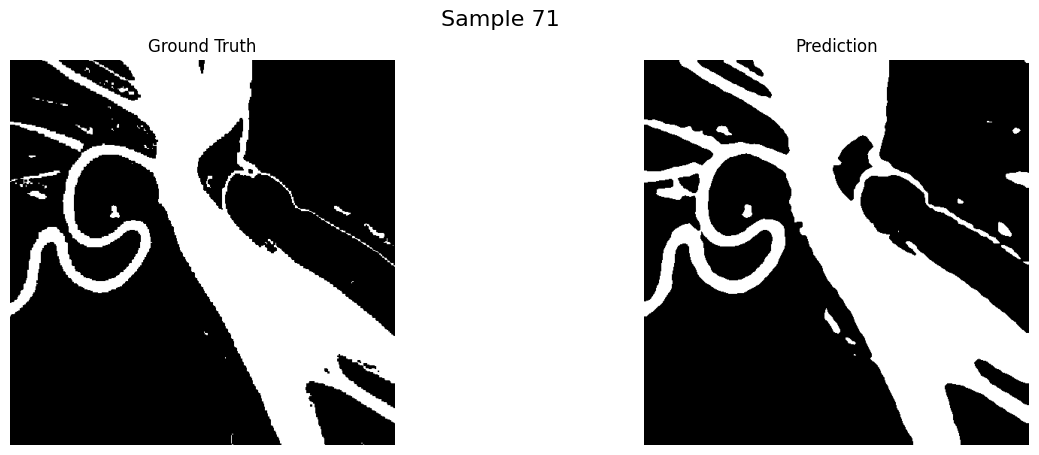

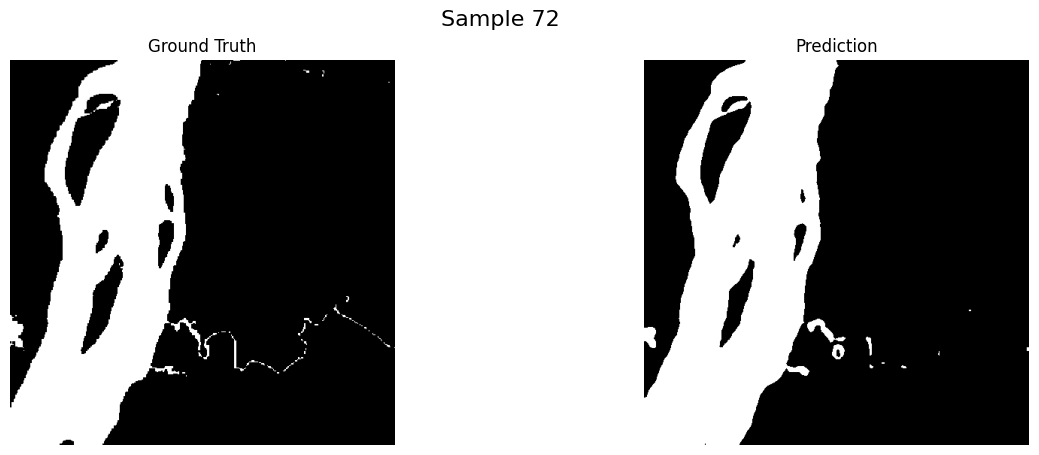

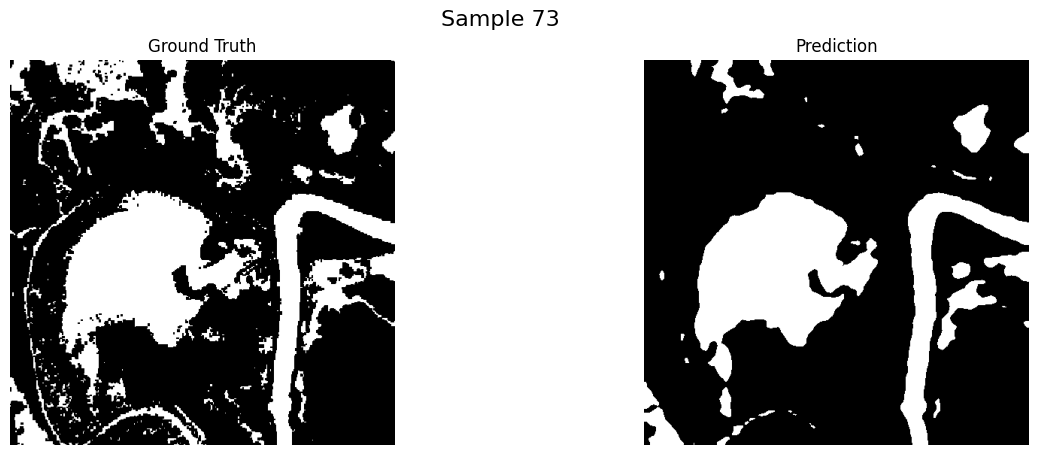

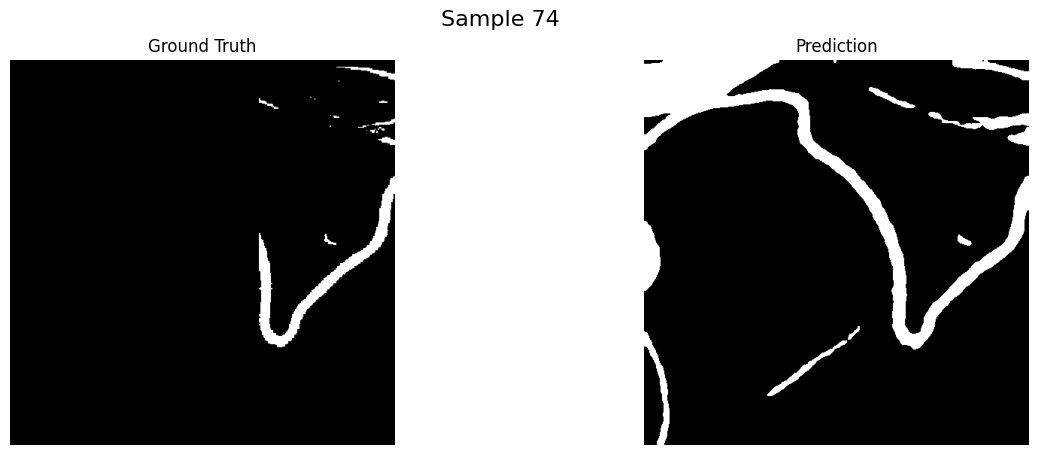

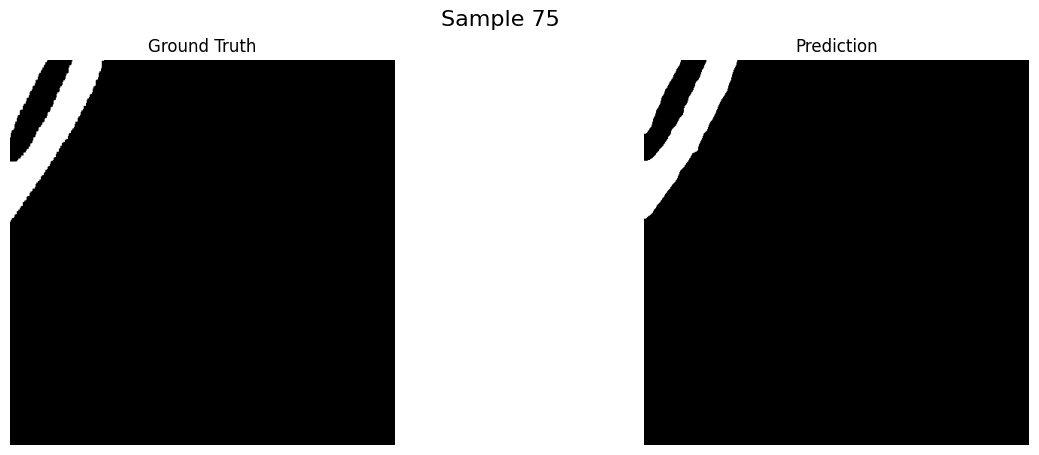

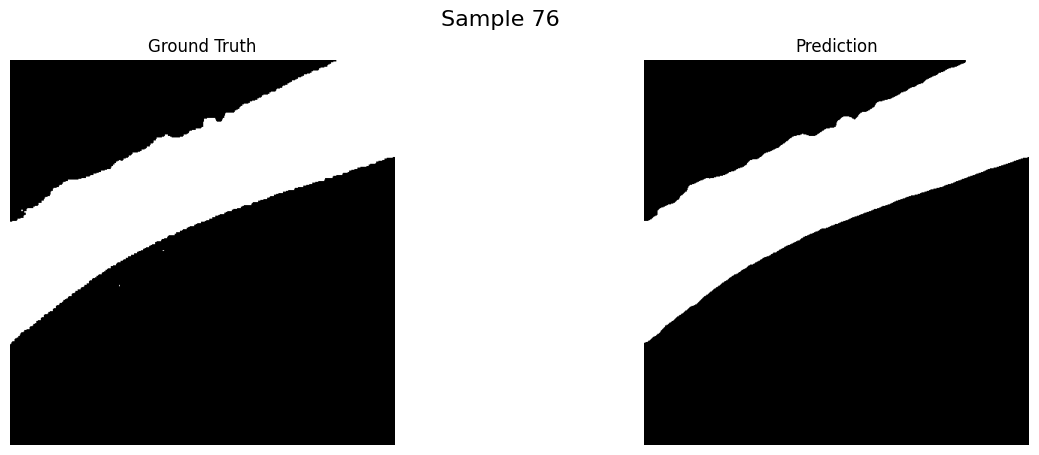

In [ ]:
compute_metrics = Evaluator(image_processor=processor, id2label=id2label, num_classes=NUM_CLASSES)

training_args = TrainingArguments(
    output_dir="maskformer_water_finetuned",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    fp16=False,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    push_to_hub=False,
    lr_scheduler_type="constant",
    # eval_do_concat_batches=False,
    # dataloader_num_workers=8,
    # dataloader_persistent_workers=True,
    # dataloader_prefetch_factor=4,
    load_best_model_at_end=True,
    # metric_for_best_model="overall_accuracy",
    eval_accumulation_steps=5,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
model.save_pretrained('mask2former_water_new')